In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List

from scipy.stats import ttest_ind

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the data

features_df = pd.read_csv("features.csv")
stores_df = pd.read_csv("stores.csv")
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

## 1. Taking a look at the data

In [3]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
test_df.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


We have to merge the different dataframes into a single one before we can fill in missing values or do EDA.

I will start by combining `stores_df` with `features_df` first, then I will combine the resulting df with `train_df` to produce the final dataframe on which we will work.

In [7]:
print(f"Number of unique store IDs in stores_df: {stores_df['Store'].nunique()}")
print(f"Number of unique store IDs in features_df: {features_df['Store'].nunique()}")

Number of unique store IDs in stores_df: 45
Number of unique store IDs in features_df: 45


In [8]:
assert all(stores_df["Store"].unique() == features_df["Store"].unique()), "Values don't match"

In [9]:
# Now we can merge the dataframes

store_feature_df = features_df.merge(stores_df, on="Store", how="inner")
store_feature_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [10]:
print(f"Shape of features_df: {features_df.shape}")
print(f"Shape of training_df: {train_df.shape}")

Shape of features_df: (8190, 12)
Shape of training_df: (421570, 5)


In [11]:
print(f"Number of unique stores in training_df: {train_df['Store'].nunique()}")

Number of unique stores in training_df: 45


In [12]:
min_date = train_df["Date"].min()
max_date = train_df["Date"].max()
print(f"Date range in train_df: {min_date} to {max_date}")

Date range in train_df: 2010-02-05 to 2012-10-26


In [13]:
# Checking if we have multiple rows for the same date

train_df.loc[train_df["Date"] == min_date]

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
143,1,2,2010-02-05,50605.27,False
286,1,3,2010-02-05,13740.12,False
429,1,4,2010-02-05,39954.04,False
572,1,5,2010-02-05,32229.38,False
...,...,...,...,...,...
420727,45,92,2010-02-05,68203.08,False
420870,45,93,2010-02-05,4002.34,False
421147,45,95,2010-02-05,63833.63,False
421292,45,97,2010-02-05,8393.22,False


For a given date, we have separate rows for each store and each department in that store. So we merge `train_df` with the `store_feature_df` on both `Store` and `Date`

In [14]:
df = train_df.merge(store_feature_df, on=["Store", "Date"], how="inner")
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


We have combined all the data in a single dataframe. We can now start dealing with missing values, perform EDA and feature engineering.

## 2. Data validation and checking

Before I can proceed with EDA, I want to check if the data that we have is valid. I want to check that columns are the correct data types and they don't contain invalid or missing data.

In [15]:
# Checking missing values

df.isna().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday_x,0
Temperature,0
Fuel_Price,0
MarkDown1,270889
MarkDown2,310322
MarkDown3,284479


Only the mark down columns have missing values. I will assume that missing value means no mark down was applied and fill in with 0

In [16]:
markdown_cols = [f"MarkDown{i}" for i in range(1, 6)]
df[markdown_cols] = df[markdown_cols].fillna(0)

Now I'll check if the data types of the columns are as expected.

In [17]:
df.dtypes

,0
Store,int64
Dept,int64
Date,object
Weekly_Sales,float64
IsHoliday_x,bool
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64


In [18]:
# Dropping one of the IsHoliday

df.drop(columns="IsHoliday_y", inplace=True, errors="ignore")
df.rename(columns={"IsHoliday_x": "IsHoliday"}, inplace=True)

In [19]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


From the description of the dataframe we see that the minimum of `Weekly_Sales` is negative. THis can not be right, let's explore weekly sales further.

In [20]:
store_dept_table = pd.pivot_table(df, index="Store",
                                  columns="Dept",
                                  values="Weekly_Sales",
                                  aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


From the pivot table, I see that there are some departments in some stores that have average weekly sales on `NaN` or less than 0. I want to check how many rows have weekly sales less than 0.

In [21]:
negative_weekly_sales = df.loc[df["Weekly_Sales"] < 0]

In [22]:
print(f"Number of rows with weekly sales less than 0: {negative_weekly_sales.shape[0]}")
print(f"Percentage of data: {(negative_weekly_sales.shape[0] / len(df.index)) * 100:.2f}")

Number of rows with weekly sales less than 0: 1285
Percentage of data: 0.30


Since this bad data is just 0.3% of the entire set, I can drop these bad rows.

In [23]:
df = df.loc[df["Weekly_Sales"] > 0]

Now I have validate the data and can proceed to do some EDA.

## 3. Exploratory Data Analysis

I'll analyze the data now, as we are interested in predicting sales, let's see the effects of different features on weekly sales

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

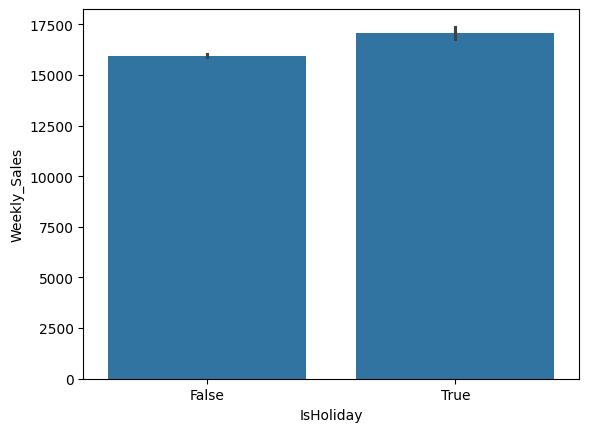

In [24]:
sns.barplot(x="IsHoliday", y="Weekly_Sales", data=df)

Let's perform a ttest to check if the difference between holiday and non-holiday sales is significant.

In [ ]:
holiday_sales = df.loc[df["IsHoliday"] == True]["Weekly_Sales"]
non_holiday_sales = df.loc[df["IsHoliday"] == False]["Weekly_Sales"]

t_stat, p_value = ttest_ind(holiday_sales, non_holiday_sales, equal_var=False)
print(f"T-statistic: {t_stat}")
print(f"P-values: {p_value}")

if p_value < 0.05:
    print("Statically significant difference between holiday and non-holiday sales")
else:
    print("No statistical significant difference between holiday and non-holiday sales")

T-statistic: 7.02547304533048
P-values: 2.1751938462199053e-12
Statistcally significant difference between holiday and non-holiday sales


Let's explore holidays further to find:

1. What holidays are in the dataset.
2. Do some of them contribute more than others towards sales (maybe Christmas)

In [26]:
holiday_df = df.loc[df["IsHoliday"] == True]
holiday_df["Date"].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [27]:
test_holiday_df = test_df.loc[test_df["IsHoliday"] == True]
test_holiday_df["Date"].unique()

array(['2012-11-23', '2012-12-28', '2013-02-08'], dtype=object)

The data has four US holidays:
1. Super Bowl: 12-Feb-2010, 11-Feb-2011, 10 Feb-2012 and 8-Feb-2013
2. Labor Day: 10-Sep-2010, 9-Sep-2011, 7-Sep-2012, 6-Sep-2012
3. Thanksgiving: 26-Nov-2010, 25-Nov-2011, 23-Nov-2012, 29-Nov-2013
4. Christmas: 31-Dec-2010, 20-Dec-2011, 28-Dec-2012, 27-Dec-2013

In [28]:
df["Super_Bowl"] = [False] * len(df.index)
df.loc[(df["Date"] == "2010-02-12") |
       (df["Date"] == "2011-02-11") |
       (df["Date"] == "2012-02-10"), "Super_Bowl"] = True

In [29]:
df["Labor_Day"] = [False] * len(df.index)
df.loc[(df["Date"] == "2010-09-10") |
       (df["Date"] == "2011-09-09") |
       (df["Date"] == "2012-09-07"), "Labor_Day"] = True

In [30]:
df["Thanksgiving"] = [False] * len(df.index)
df.loc[(df["Date"] == "2010-11-26") |
       (df["Date"] == "2011-11-25"), "Thanksgiving"] = True

In [31]:
df["Christmas"] = [False] * len(df.index)
df.loc[(df["Date"] == "2010-12-31") |
       (df["Date"] == "2011-12-30"), "Christmas"] = True

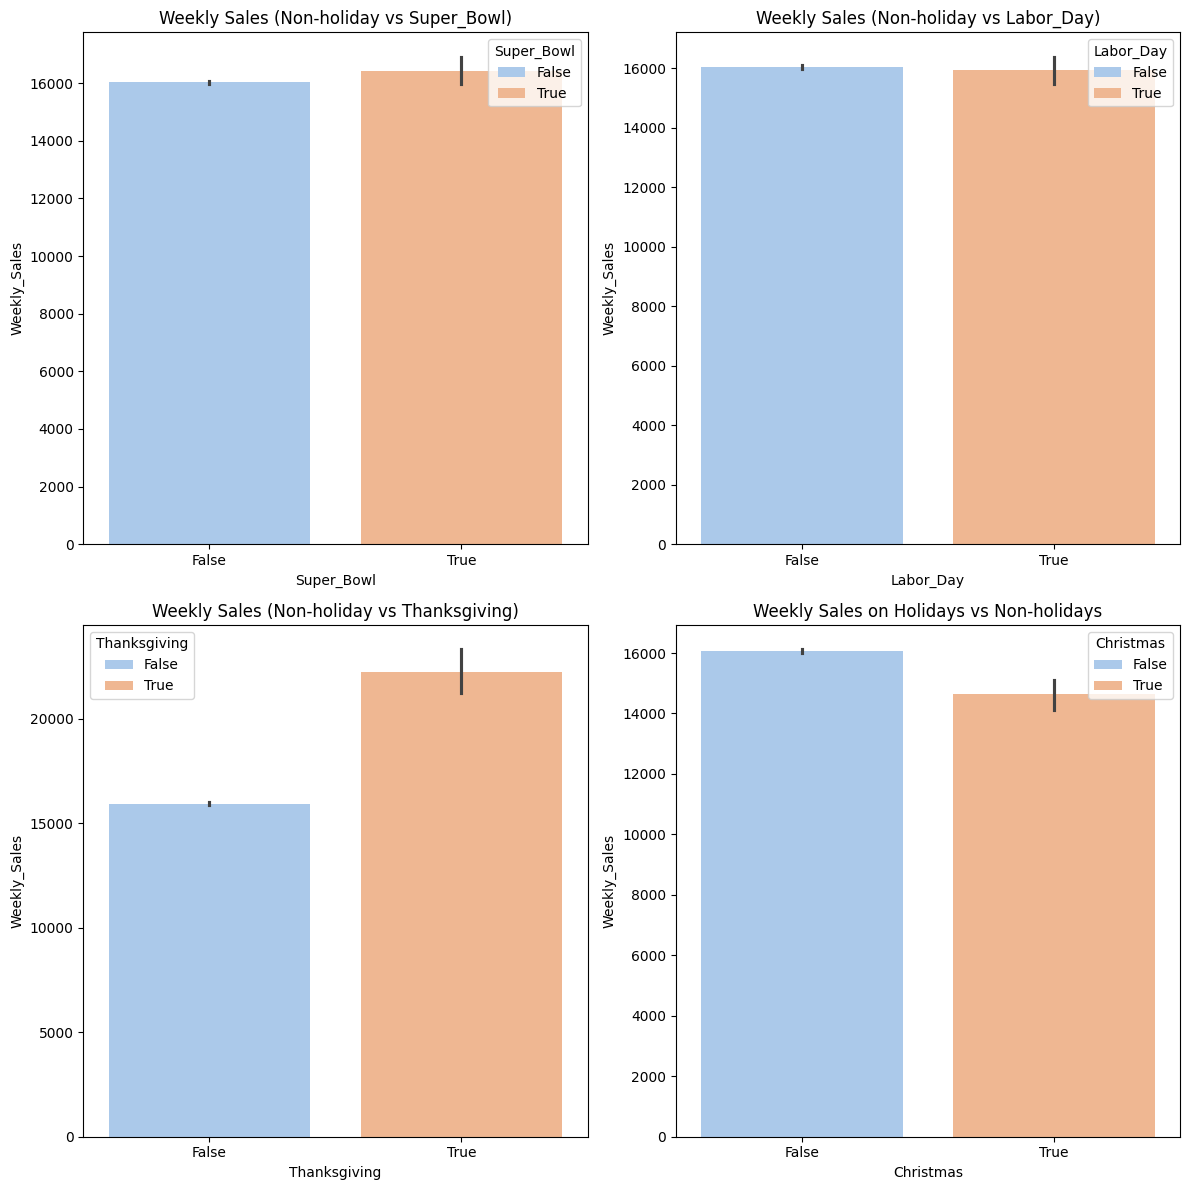

In [32]:
holidays = ["Super_Bowl", "Labor_Day", "Thanksgiving", "Christmas"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for ax, holiday in zip(axes.flat, holidays):
    sns.barplot(x=holiday, y="Weekly_Sales", data=df, ax=ax, hue=holiday, palette="pastel")
    ax.set_title(f"Weekly Sales (Non-holiday vs {holiday})")

plt.title("Weekly Sales on Holidays vs Non-holidays")
plt.tight_layout()
plt.show()

This graph tells me that Thanksgiving affects sales by a wider margin than other holidays like super bowl and labor day. In case of Christmas, weekly sales are less than non-holiday weeks. As people tend to buy gifts before the christmas week this is expected.

Next let's see how weekly sales and type of store are related.

In [33]:
df["Type"].value_counts()

,count
Type,
A,214961
B,162787
C,42464


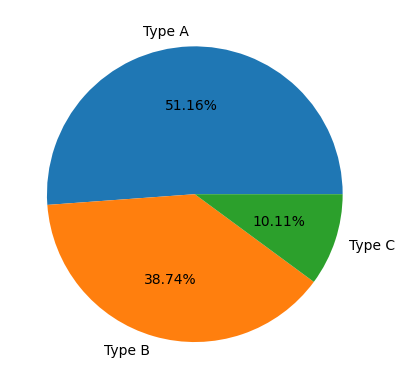

In [34]:
store_labels = [f"Type {x}" for x in "ABC"]
store_type_percentages = [df["Type"].value_counts().iloc[i] / len(df.index) for i in range(3)]

plt.pie(store_type_percentages, labels=store_labels, autopct="%1.2f%%")
plt.show()

More than half the stores are of type A, so it is likely that the sales for type A stores should be greater than the other stores. Let's explore weekly sales per type of store.

In [35]:
def get_weekly_sales_mean(df: pd.DataFrame = df,
                          holiday: str = "Super_Bowl") -> List[float]:
    df_groupby = df.groupby(by=[holiday, "Type"])
    return df_groupby["Weekly_Sales"].mean().values[3:]

In [36]:
superbowl_means = get_weekly_sales_mean(df=df, holiday="Super_Bowl")
labor_day_means = get_weekly_sales_mean(df=df, holiday="Labor_Day")
thanksgiving_means = get_weekly_sales_mean(df=df, holiday="Thanksgiving")
christmas_means = get_weekly_sales_mean(df=df, holiday="Christmas")

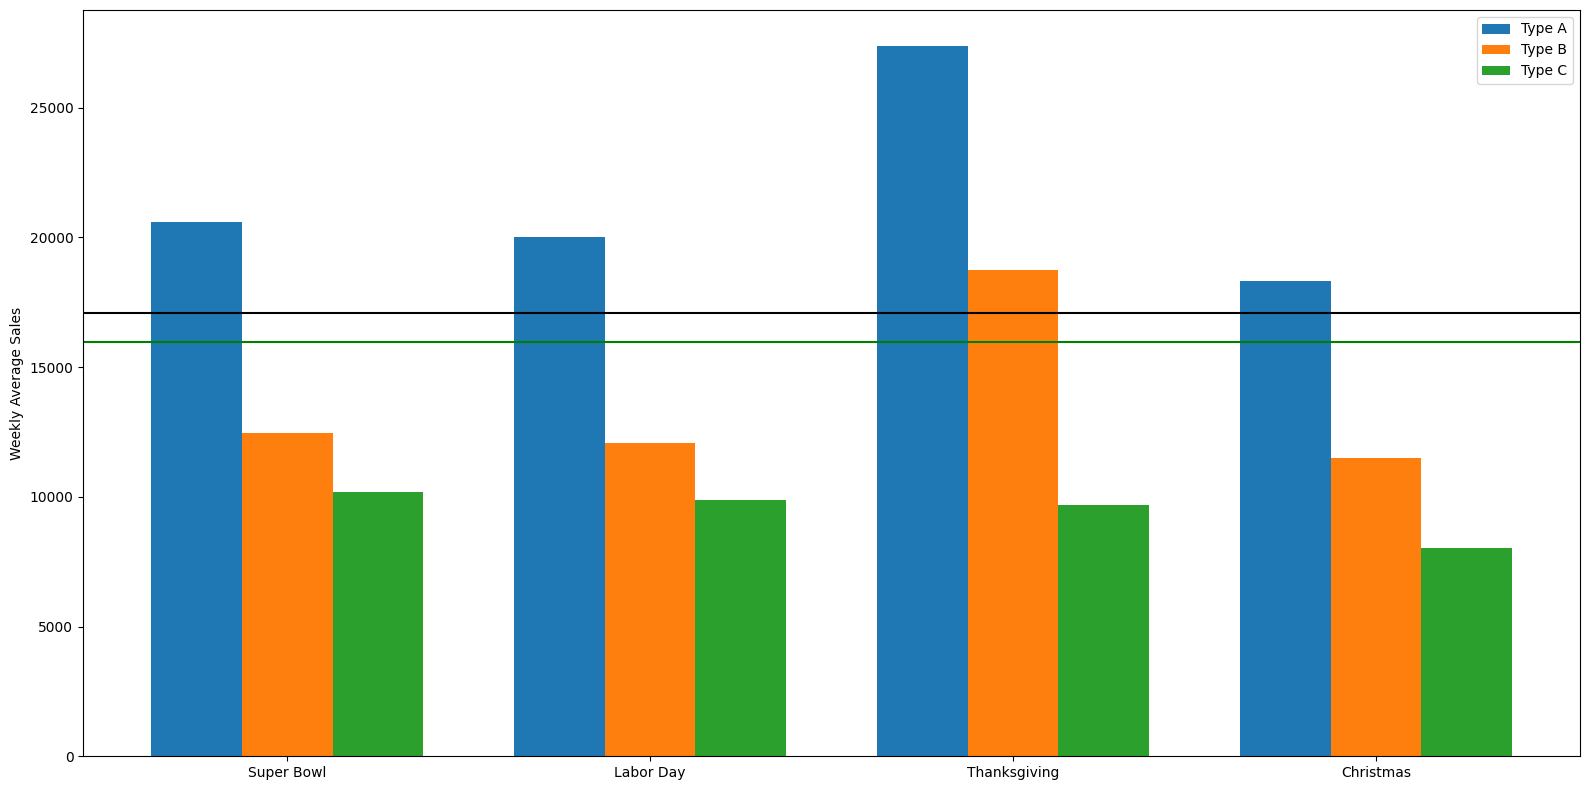

In [37]:
width = 0.25
x = np.arange(len(holidays))
holidays = ["Super Bowl", "Labor Day", "Thanksgiving", "Christmas"]
holiday_means = [superbowl_means, labor_day_means, thanksgiving_means, christmas_means]
A_means = [x[0] for x in holiday_means]
B_means = [x[1] for x in holiday_means]
C_means = [x[2] for x in holiday_means]

fig, axes = plt.subplots(figsize=(16, 8))
axes.bar(x - width, A_means, width, label="Type A")
axes.bar(x, B_means, width, label="Type B")
axes.bar(x + width, C_means, width, label="Type C")

axes.set_ylabel("Weekly Average Sales")
axes.set_xticks(x)
axes.set_xticklabels(holidays)
axes.legend()

holiday_mean = df.loc[df["IsHoliday"] == True]["Weekly_Sales"].mean()
non_holiday_mean = df.loc[df["IsHoliday"] == False]["Weekly_Sales"].mean()
plt.axhline(y=holiday_mean, color="black", label="Overall Holiday Week Mean Sales")
plt.axhline(y=non_holiday_mean, color="green", label="Overall Non-Holiday Week Mean Sales")

fig.tight_layout()
plt.show()

My previous assumption is correct, type A stores lead the sales. Another interesting thing I noticed is that sales of type C store look to be unaffected by holidays.

In [38]:
df.loc[df["Type"] == "C"].groupby(by="IsHoliday")["Weekly_Sales"].mean()

,Weekly_Sales
IsHoliday,
False,9548.251972
True,9565.533649


Let's take a look at the sales per store and per department.

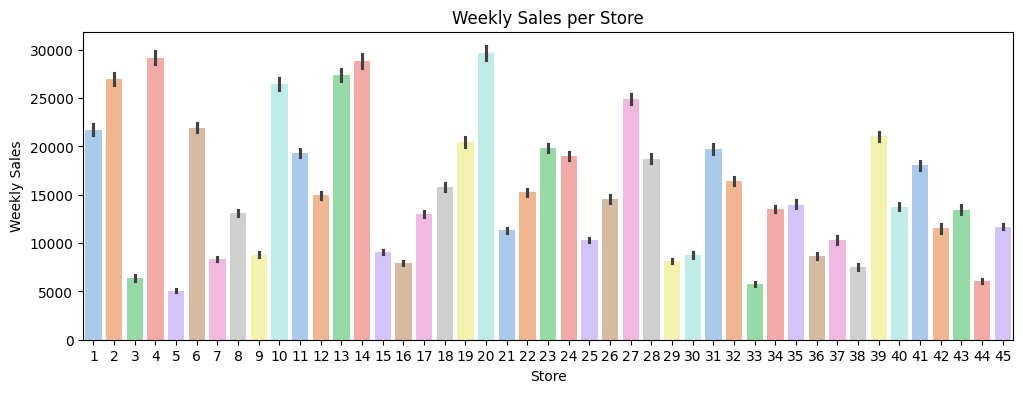

In [39]:
# Sales per store

plt.figure(figsize=(12, 4))
sns.barplot(x="Store", y="Weekly_Sales", data=df, hue="Store", palette="pastel")
plt.title("Weekly Sales per Store")
plt.xlabel("Store")
plt.ylabel("Weekly Sales")
plt.legend().remove()
plt.show()

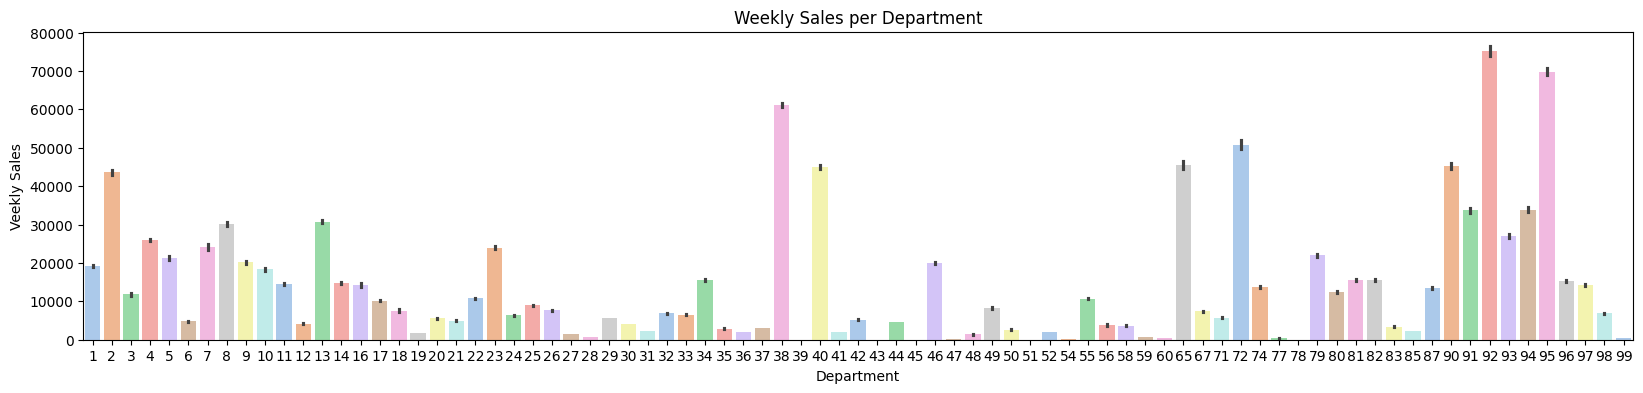

In [40]:
# Sales per department

plt.figure(figsize=(20, 4))
sns.barplot(x="Dept", y="Weekly_Sales", data=df, hue="Dept", palette="pastel")
plt.title("Weekly Sales per Department")
plt.xlabel("Department")
plt.ylabel("Veekly Sales")
plt.legend().remove()
plt.show()

From the graphs I see that store 20 is the best performing store followed closely by stores 4 and 14. Departments 92, 95 and 36 are the best performing departments.

I will now change the `Date` column in `datetime` data type and then extract useful information like month, week, year. I will also create lag column which will have dates from previous week, this will help the model in learning changes in the sales between last week and this week. I will also create a column for 3 weekly rolling average sales.

In [41]:
df["Date"] = pd.to_datetime(df["Date"])
df["Week"] = df["Date"].dt.isocalendar().week
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Lag_1"] = df["Weekly_Sales"].shift(1)
df["Rolling_avg_3_week"] = df["Weekly_Sales"].rolling(window=3).mean()

In [42]:
# Filling the Nans with 0

df.fillna(value=0, inplace=True)

I'll now explore how the sales look on monthly and yearly basis. I'll also visualize the rolling average.

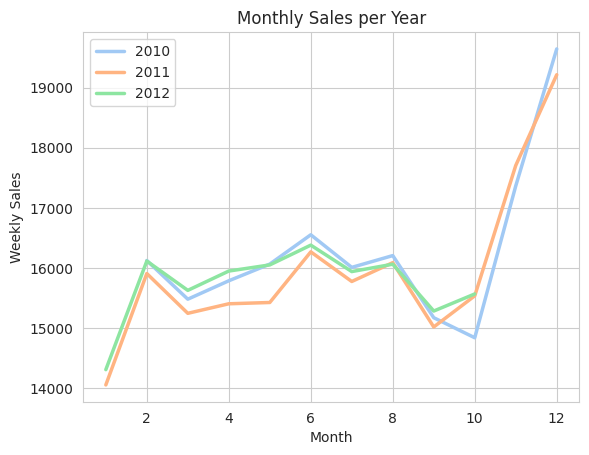

In [43]:
# Viewing monthly sales trends

monthly_sales = df.groupby(by=["Year", "Month"])["Weekly_Sales"].mean().unstack()

sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.lineplot(x=range(1, 13), y=monthly_sales.iloc[0], linewidth=2.5, label="2010")
sns.lineplot(x=range(1, 13), y=monthly_sales.iloc[1], linewidth=2.5, label="2011")
sns.lineplot(x=range(1, 13), y=monthly_sales.iloc[2], linewidth=2.5, label="2012")

plt.title("Monthly Sales per Year")
plt.xlabel("Month")
plt.ylabel("Weekly Sales")
plt.show()

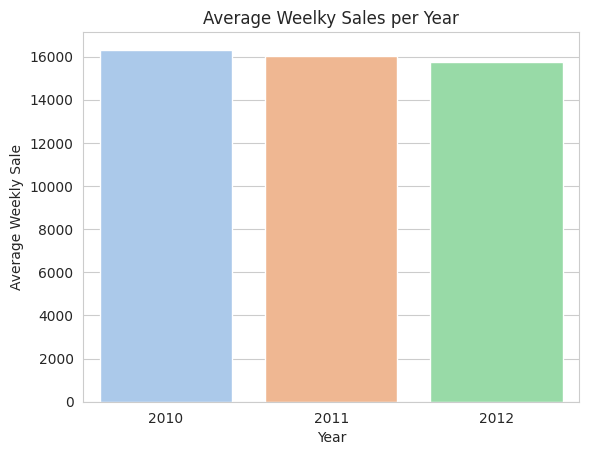

In [44]:
yearly_sales = df.groupby(by="Year")["Weekly_Sales"].mean().reset_index()
sns.barplot(data=yearly_sales, x="Year", y="Weekly_Sales", hue="Year", palette="pastel")
plt.title("Average Weelky Sales per Year")
plt.xlabel("Year")
plt.ylabel("Average Weekly Sale")
plt.legend().remove()
plt.show()

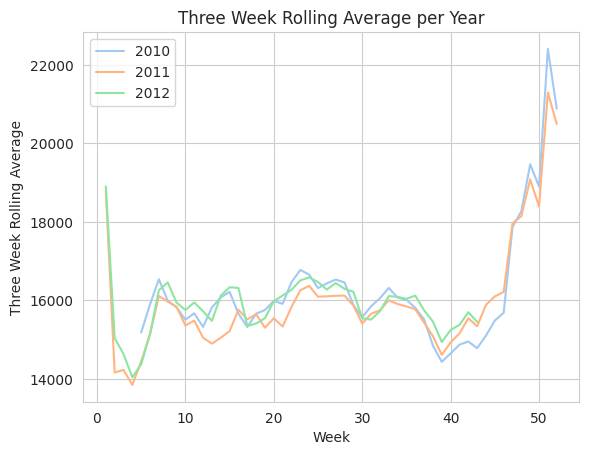

In [45]:
sns.set_palette("pastel")
sns.lineplot(data=df.loc[df["Year"] == 2010], x="Week", y="Rolling_avg_3_week", linewidth=1.5, errorbar=None, label="2010")
sns.lineplot(data=df.loc[df["Year"] == 2011], x="Week", y="Rolling_avg_3_week", linewidth=1.5, errorbar=None, label="2011")
sns.lineplot(data=df.loc[df["Year"] == 2012], x="Week", y="Rolling_avg_3_week", linewidth=1.5, errorbar=None, label="2012")
plt.title("Three Week Rolling Average per Year")
plt.xlabel("Week")
plt.ylabel("Three Week Rolling Average")
plt.show()

From the graphs I can infer that weekly average has remained almost same in the three years and average weekly sales tend to shoot up during November, DEcember of the year and then goes down in February and March.

In [46]:
# Saving the cleaned data
df.to_csv("clean_data.csv")

## Model Building

Now that I have cleaned and prepared the data, I'll start modeling. I will train and compare Linear Regression, Random Forest Regressor and Gradient Boosting Regressor models from sklearn. After that I will check for Stationarity of the data using Augmented Dickey-Fuller (ADF) test, then train ARIMA or SARIMA models.

Before I can start modeling, I will drop redundant columns like `Date` as all date related information is already captured by `Week`, `Month` and `Year` columns. I'll also drop columns that have very week to no correlation with `Weekly_Sales`.

I will also map `Type` column to integers (A -> 1, B -> 2, C -> 3) and convert boolean columns like `IsHoliday` and `Christmas` to integers (`True` -> 1, `False` -> 0)

In [47]:
data_df = pd.read_csv("clean_data.csv", index_col=0)

In [48]:
type_map = {"A": 1, "B": 2, "C": 3}
data_df["Type"] = data_df["Type"].apply(lambda x: type_map[x])

In [49]:
data_df["IsHoliday"] = data_df["IsHoliday"].astype(int)
data_df["Super_Bowl"] = data_df["Super_Bowl"].astype(int)
data_df["Labor_Day"] = data_df["Labor_Day"].astype(int)
data_df["Thanksgiving"] = data_df["Thanksgiving"].astype(int)
data_df["Christmas"] = data_df["Christmas"].astype(int)

In [50]:
# Sorting the dataframe by Date

n_train = int(0.7 * len(data_df.index))
data_df["Date"] = pd.to_datetime(data_df["Date"])
df_new = data_df.sort_values(by="Date", ascending=True)

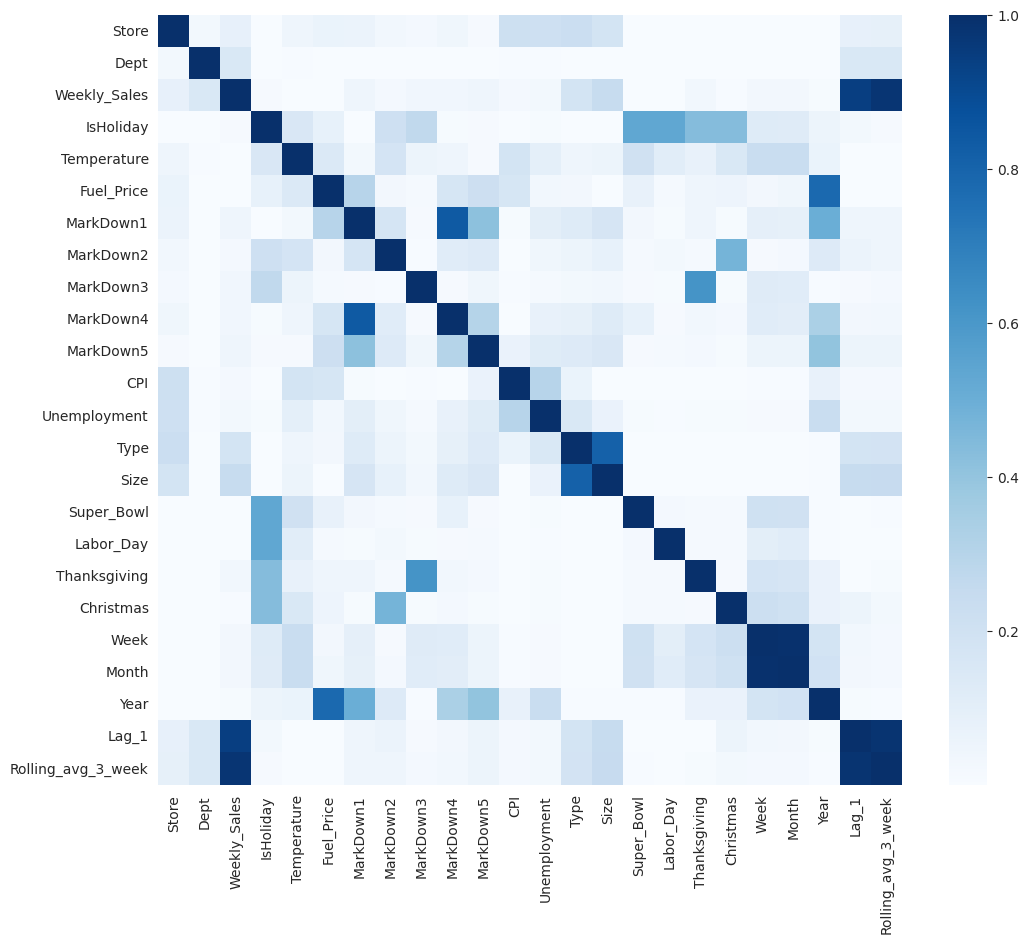

In [51]:
plt.figure(figsize=(12, 10))
correlations = df_new.drop(columns=["Date"]).corr()
sns.heatmap(correlations.abs(), cmap="Blues")
plt.show()

From the correlation matrix, I see that `Weekly_Sales` is correlated with `Store`, `Dept`, `Type`, `Size` and `Markdown1`. It is strongly correlated with `Rolling_avg_3_week` which is expected. Other features have week correlation with `Weekly_Sales`.

Now I can start modelling.

In [52]:
train_df = df_new[:n_train]
test_df = df_new[n_train:]

X_train = train_df.drop(columns=["Weekly_Sales", "Date"])
X_test = test_df.drop(columns=["Weekly_Sales", "Date"])
y_train = train_df["Weekly_Sales"]
y_test = test_df["Weekly_Sales"]

In [53]:
# Defining the weighted error function

def weighted_mean_absolute_error(y_test, y_pred, test_data=X_test):
    weights = test_data["IsHoliday"].apply(lambda x: 5 if x else 1)
    return np.sum(weights * np.abs(y_test - y_pred), axis=0) / np.sum(weights)

In [54]:
def plot_model_predictions(y_pred: pd.Series,
                           train_data: pd.DataFrame = train_df,
                           test_data: pd.DataFrame = test_df,
                           date_index: bool = False):
    plt.figure(figsize=(30, 10))
    sns.set_palette("pastel")

    if not date_index:
        test_dates = test_data["Date"]
        print(f"Min test date: {test_dates.min()} | Max test date: {test_dates.max()}")
        sns.lineplot(data=train_data, x="Date", y="Weekly_Sales", linewidth=3, errorbar=None, label="Training Values")
        sns.lineplot(data=test_data, x="Date", y="Weekly_Sales", linewidth=3, errorbar=None, label="Actual Values")
        sns.lineplot(x=test_dates, y=y_pred, linewidth=2.5, errorbar=None, label="Predicted Values")
    else:
        test_dates = test_data.index
        sns.lineplot(x=train_data.index, y=train_data["Weekly_Sales"], linewidth=3, errorbar=None, label="Training Values")
        sns.lineplot(x=test_data.index, y=test_data["Weekly_Sales"], linewidth=3, errorbar=None, label="Actual Values")
        sns.lineplot(x=test_dates, y=y_pred, linewidth=2.5, errorbar=None, label="Predicted Values")

    plt.title("Prediction of Weekly Sales")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.show()

In [55]:
# 1. Linear Regression

lr = LinearRegression()
scaler = RobustScaler()
pipe = Pipeline([
    ("Scaler", scaler),
    ("Regressor", lr)
])

# Removing Lag_1 column for Linear Regression
pipe.fit(X_train, y_train)

Pipeline(steps=[('Scaler', RobustScaler()), ('Regressor', LinearRegression())])

In [56]:
# Removing Lag_1 for logistic regression

y_pred = pipe.predict(X_test)
error = weighted_mean_absolute_error(y_test, y_pred)
print(f"Weighted mean absolute error (Linear Regrission): {error:.2f}")

Weighted mean absolute error (Linear Regrission): 1948.69


Min test date: 2012-01-06 00:00:00 | Max test date: 2012-10-26 00:00:00


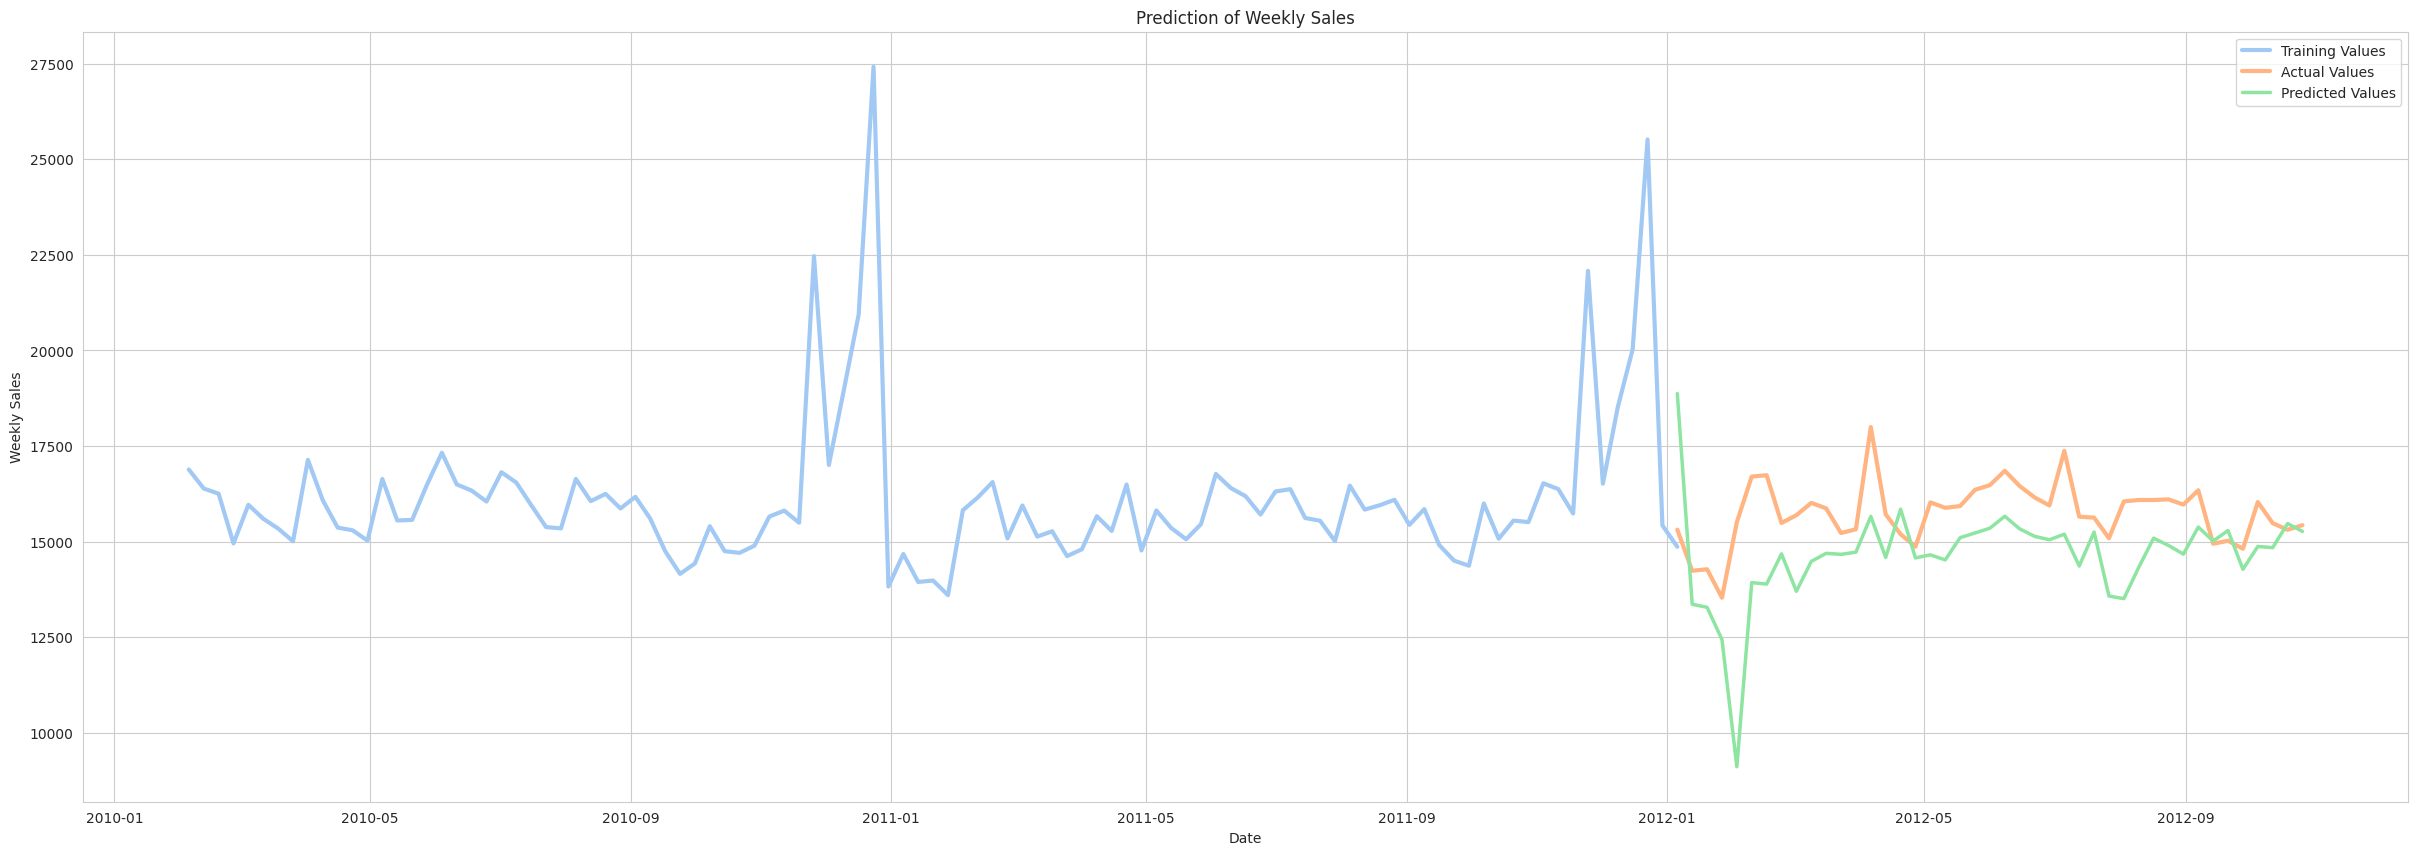

In [57]:
plot_model_predictions(y_pred)

The basic regression model does not seam to capture the weekly sales accurately. I will now train more models and see which performs best.

In [58]:
rf_regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features="sqrt",
                                     max_depth=30, min_samples_split=10)
pipe = Pipeline([
    ("Scaler", scaler),
    ("Regressor", rf_regressor)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('Scaler', RobustScaler()),
                ('Regressor',
                 RandomForestRegressor(max_depth=30, max_features='sqrt',
                                       min_samples_split=10, n_jobs=-1))])

In [59]:
y_pred = pipe.predict(X_test)
error = weighted_mean_absolute_error(y_test, y_pred)
print(f"Weighted mean absolute error (Random Forest Regressor): {error:.2f}")

Weighted mean absolute error (Random Forest Regressor): 1448.60


Min test date: 2012-01-06 00:00:00 | Max test date: 2012-10-26 00:00:00


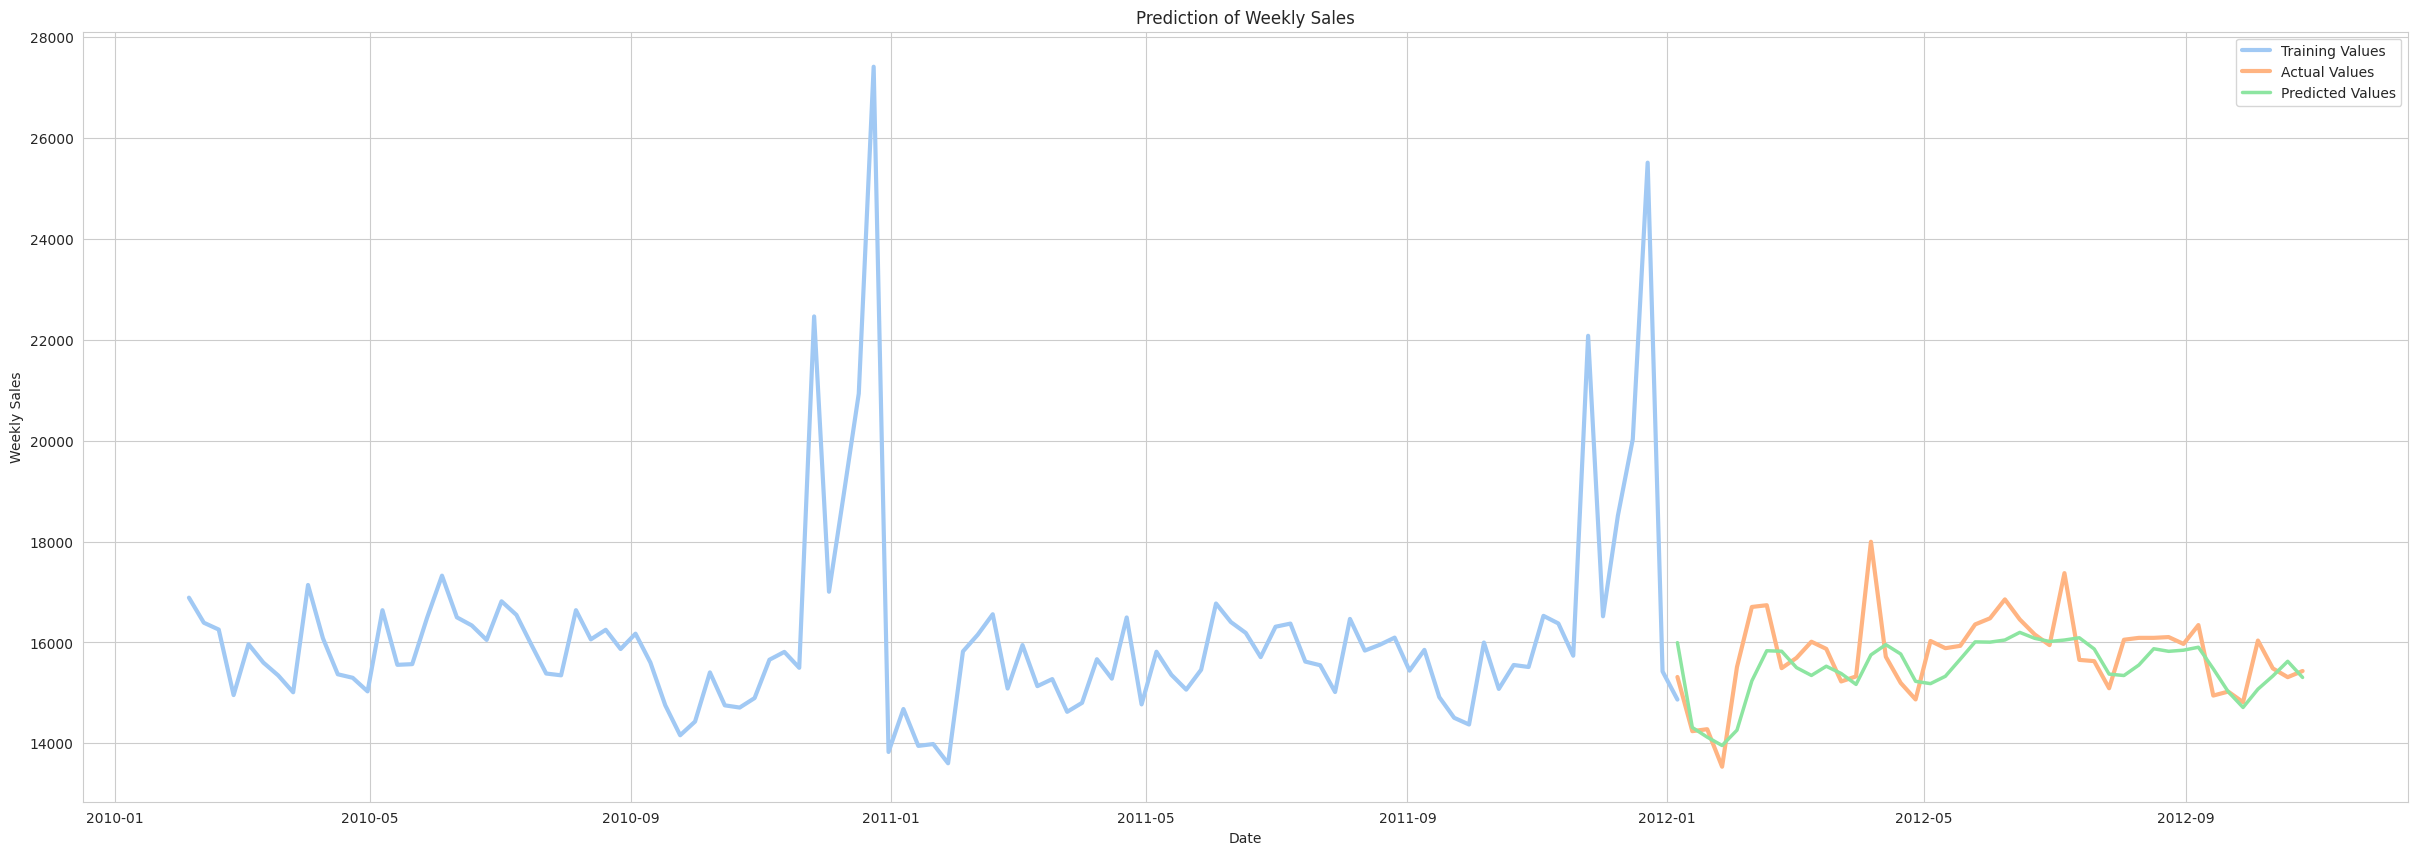

In [60]:
plot_model_predictions(y_pred)

Predictions of Random Forest Regressor (RFR) look much better than Linear Regression's. The weighted mean absolute error for the RFR is also lesser than the previous model.

I'll check the feature importance of the RFR and remove some of the least important features. I'll then check if this improves the error.

In [61]:
feature_importance = rf_regressor.feature_importances_
feature_names = X_train.columns
indices = np.argsort(feature_importance)[::-1]

print("Feature importance (Random Forest Regressor):")
for f in range(X_train.shape[1]):
    print(f"Feature {feature_names[indices[f]]}: {feature_importance[indices[f]]:.4f}")

Feature importance (Random Forest Regressor):
Feature Rolling_avg_3_week: 0.4998
Feature Lag_1: 0.3645
Feature Dept: 0.0608
Feature Size: 0.0225
Feature Type: 0.0084
Feature Store: 0.0082
Feature Week: 0.0070
Feature CPI: 0.0040
Feature Unemployment: 0.0037
Feature Temperature: 0.0030
Feature Thanksgiving: 0.0028
Feature Fuel_Price: 0.0025
Feature MarkDown3: 0.0024
Feature Christmas: 0.0022
Feature Month: 0.0021
Feature IsHoliday: 0.0014
Feature MarkDown4: 0.0011
Feature MarkDown2: 0.0010
Feature MarkDown5: 0.0010
Feature MarkDown1: 0.0009
Feature Year: 0.0004
Feature Super_Bowl: 0.0002
Feature Labor_Day: 0.0001


In [62]:
# Dropping least important features to see if it improves wmae

columns_to_drop = ["Christmas", "MarkDown5", "MarkDown4", "MarkDown1", "MarkDown2", "IsHoliday", "Year", "Super_Bowl", "Labor_Day"]
X_train_copy = X_train.drop(columns=columns_to_drop)

In [63]:
rf_regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features="sqrt",
                                     max_depth=30, min_samples_split=10)

pipe = Pipeline([
    ("Scaler", scaler),
    ("Regressor", rf_regressor)
])

pipe.fit(X_train_copy, y_train)

Pipeline(steps=[('Scaler', RobustScaler()),
                ('Regressor',
                 RandomForestRegressor(max_depth=30, max_features='sqrt',
                                       min_samples_split=10, n_jobs=-1))])

In [64]:
X_test_copy = X_test.drop(columns=columns_to_drop)

y_pred = pipe.predict(X_test_copy)
error = weighted_mean_absolute_error(y_test, y_pred)
print(f"Weighted mean absolute error (Random Forest Regressor reduced feature set): {error:.2f}")

Weighted mean absolute error (Random Forest Regressor reduced feature set): 1246.67


Min test date: 2012-01-06 00:00:00 | Max test date: 2012-10-26 00:00:00


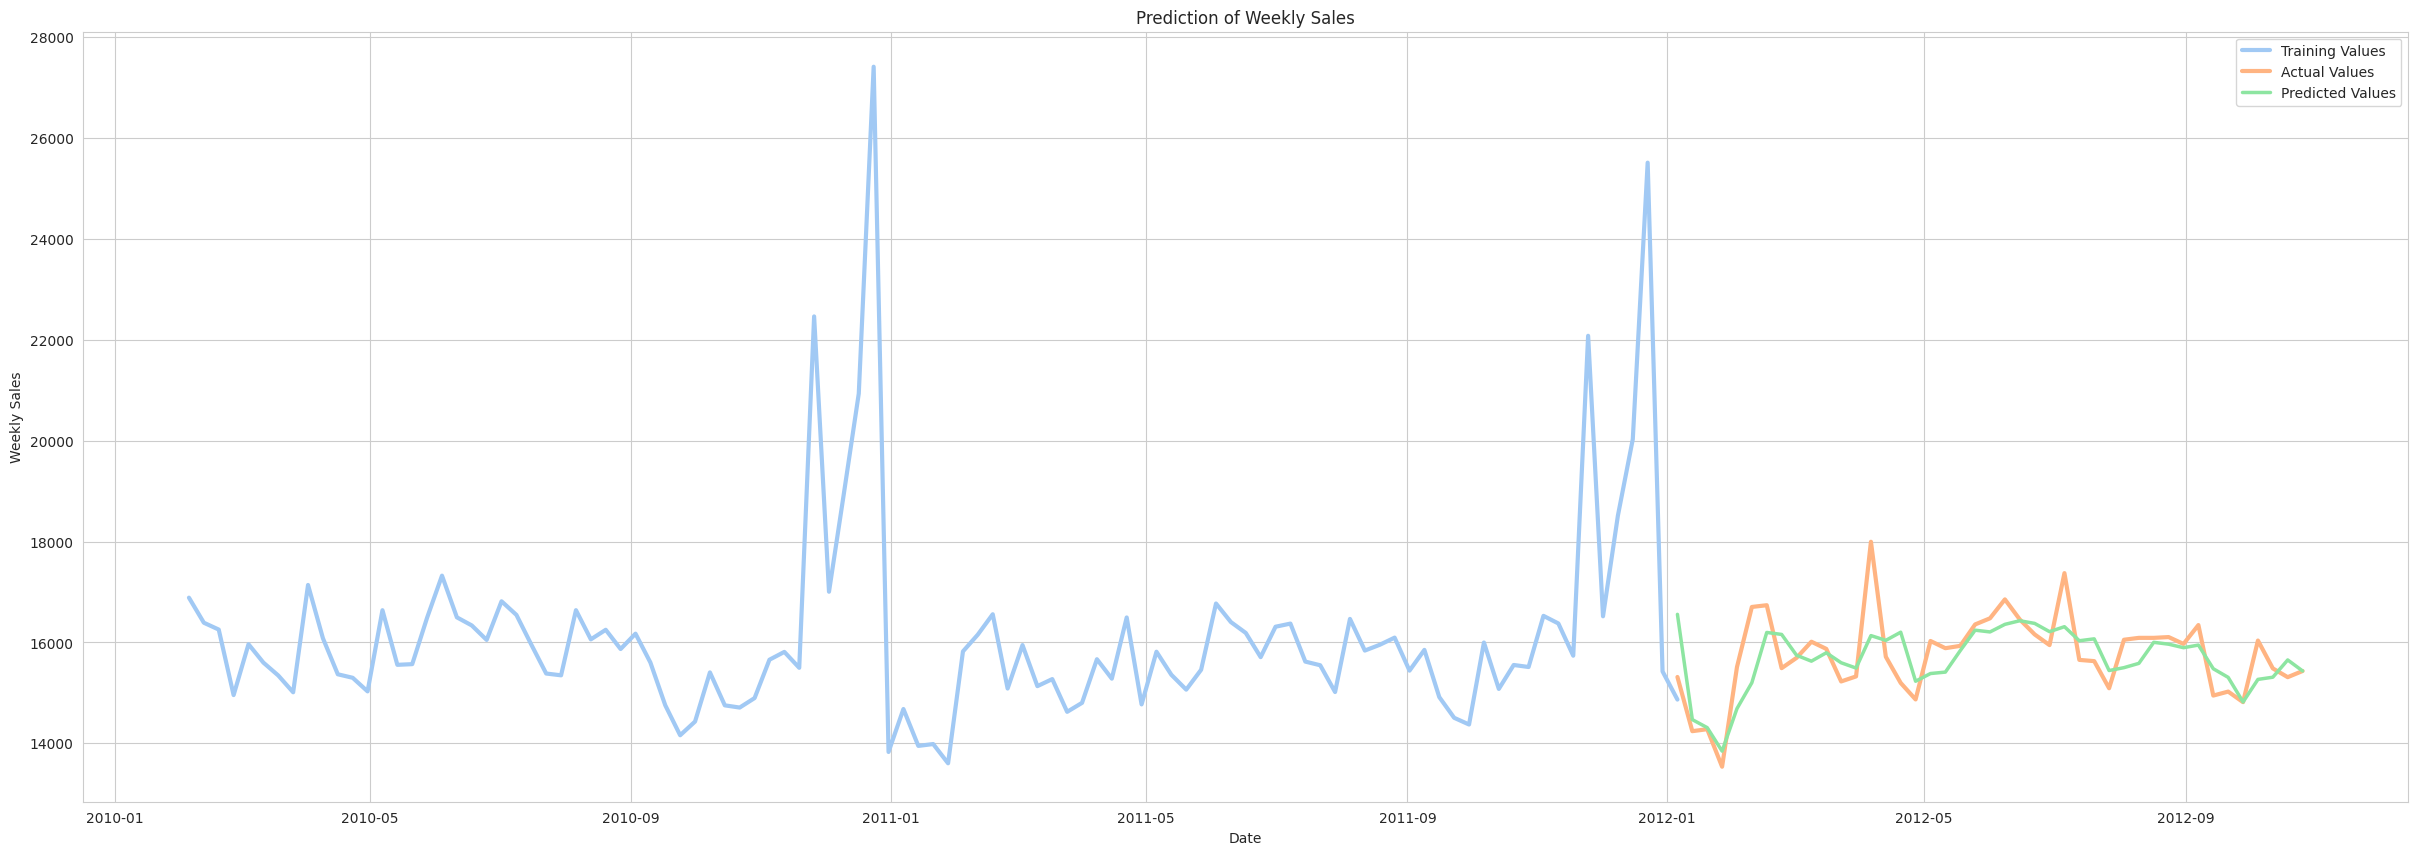

In [65]:
plot_model_predictions(y_pred)

Dropping less important features improved the model. Now I'll try the `GradientBoostingRegressor` model.

In [66]:
gb_regressor = GradientBoostingRegressor()

pipe = Pipeline([
    ("Scaler", scaler),
    ("Regressor", gb_regressor)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('Scaler', RobustScaler()),
                ('Regressor', GradientBoostingRegressor())])

In [67]:
y_pred = pipe.predict(X_test)
error = weighted_mean_absolute_error(y_test, y_pred)
print(f"Weighted mean absolute error (Gradient Boosting Regressor): {error:.2f}")

Weighted mean absolute error (Gradient Boosting Regressor): 1273.17


Min test date: 2012-01-06 00:00:00 | Max test date: 2012-10-26 00:00:00


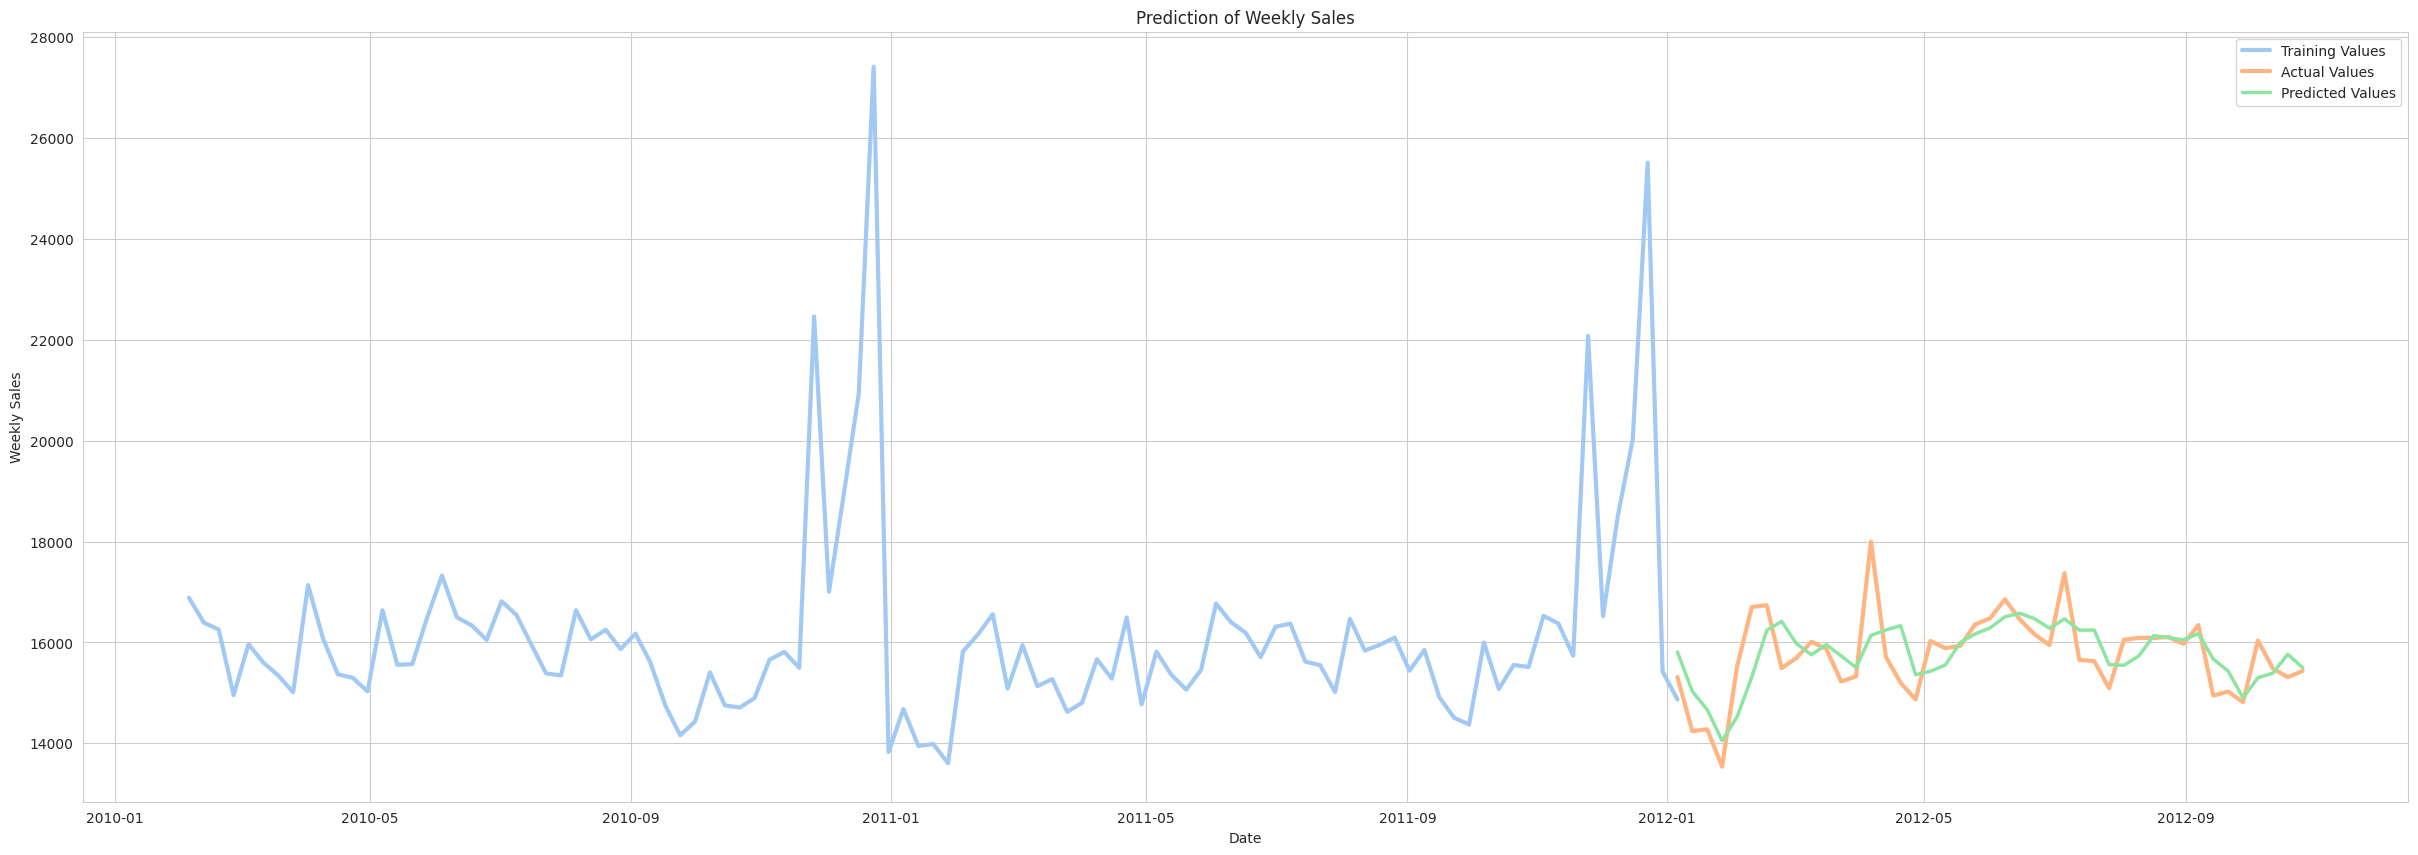

In [68]:
plot_model_predictions(y_pred)

I'll drop the least important features and see if that improves the model performance.

In [69]:
feature_importance = gb_regressor.feature_importances_
feature_names = X_train.columns
indices = np.argsort(feature_importance)[::-1]

print("Feature importance (Gradient Boosting Regressor):")
for f in range(X_train.shape[1]):
    print(f"Feature {feature_names[indices[f]]}: {feature_importance[indices[f]]:.4f}")

Feature importance (Gradient Boosting Regressor):
Feature Rolling_avg_3_week: 0.9737
Feature Thanksgiving: 0.0090
Feature Lag_1: 0.0073
Feature Week: 0.0053
Feature Dept: 0.0023
Feature Christmas: 0.0012
Feature IsHoliday: 0.0004
Feature Super_Bowl: 0.0004
Feature MarkDown5: 0.0001
Feature CPI: 0.0001
Feature Store: 0.0000
Feature Month: 0.0000
Feature Temperature: 0.0000
Feature MarkDown4: 0.0000
Feature MarkDown3: 0.0000
Feature Size: 0.0000
Feature Fuel_Price: 0.0000
Feature Unemployment: 0.0000
Feature Year: 0.0000
Feature MarkDown1: 0.0000
Feature Type: 0.0000
Feature Labor_Day: 0.0000
Feature MarkDown2: 0.0000


In [70]:
columns_to_drop = ["Super_Bowl", "Month", "MarkDown5", "CPI", "Store",
                   "Temperature", "Fuel_Price", "IsHoliday", "MarkDown4",
                   "MarkDown3", "MarkDown1", "Size", "Unemployment", "Type",
                   "Labor_Day", "MarkDown2", "Year"]
X_train_copy = X_train.drop(columns=columns_to_drop)

In [71]:
gb_regressor = GradientBoostingRegressor()

pipe = Pipeline([
    ("Scaler", scaler),
    ("Regressor", gb_regressor)
])

pipe.fit(X_train_copy, y_train)

Pipeline(steps=[('Scaler', RobustScaler()),
                ('Regressor', GradientBoostingRegressor())])

In [72]:
X_test_copy = X_test.drop(columns=columns_to_drop)

y_pred = pipe.predict(X_test_copy)
error = weighted_mean_absolute_error(y_test, y_pred)
print(f"Weighted mean absolute error (Gradient Boosting Regressor reduced feature set): {error:.2f}")

Weighted mean absolute error (Gradient Boosting Regressor reduced feature set): 1272.40


Min test date: 2012-01-06 00:00:00 | Max test date: 2012-10-26 00:00:00


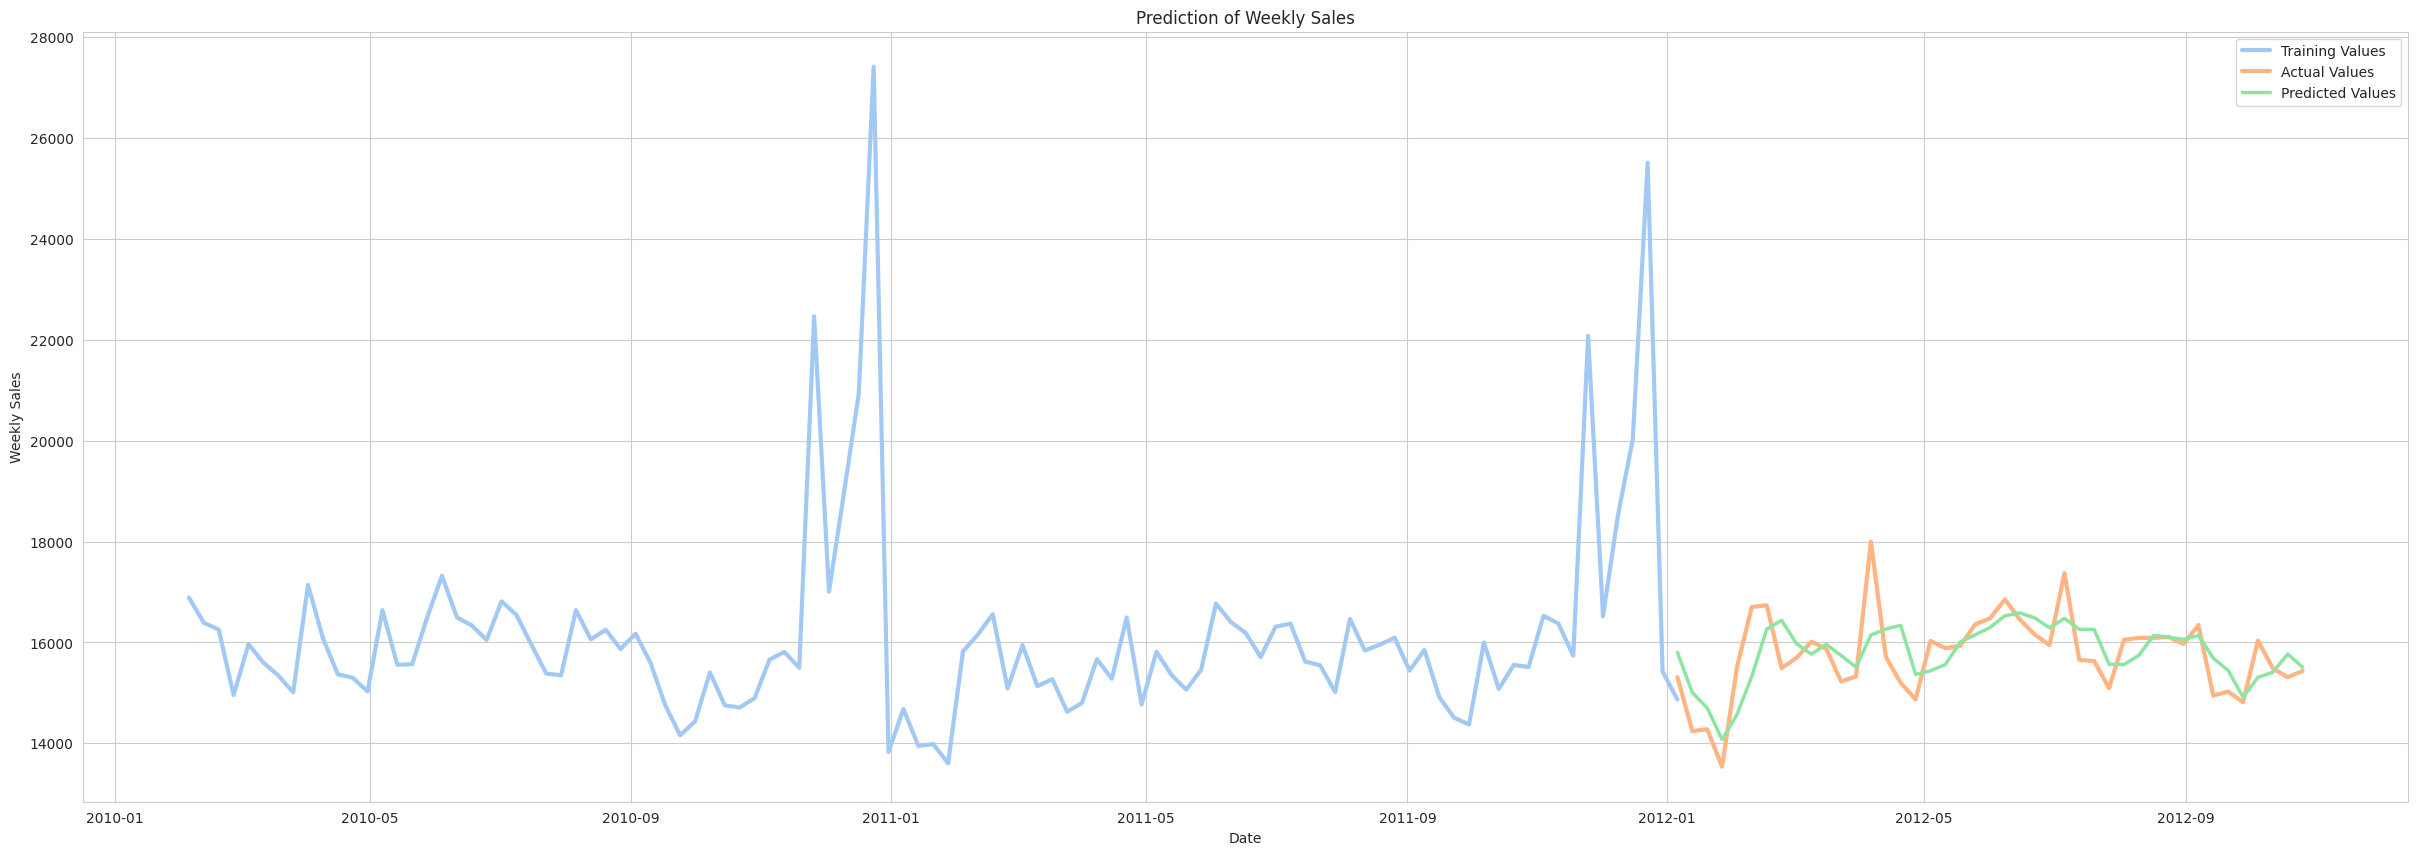

In [73]:
plot_model_predictions(y_pred)

Removing the less important features did not change the Gradient Boosting Regressors performance.

## 4. Time Series Models

I will now move on to trying the ARIMA models. I will start by checking stationarity of this data by plotting weekly sales to see if there is any observable trend or seasonality (there is).

In [74]:
df = pd.read_csv("clean_data.csv", index_col=0)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Week,Month,Year,Lag_1,Rolling_avg_3_week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,151315,False,False,False,False,5,2,2010,0.00,0.000000
140804,15,21,2010-02-05,3253.19,False,19.83,2.954,0.0,0.0,0.0,...,123737,False,False,False,False,5,2,2010,3271.80,3547.820000
140661,15,20,2010-02-05,4606.90,False,19.83,2.954,0.0,0.0,0.0,...,123737,False,False,False,False,5,2,2010,1046.58,2288.443333
140518,15,19,2010-02-05,1381.40,False,19.83,2.954,0.0,0.0,0.0,...,123737,False,False,False,False,5,2,2010,7041.82,4519.006667
140408,15,18,2010-02-05,2239.25,False,19.83,2.954,0.0,0.0,0.0,...,123737,False,False,False,False,5,2,2010,10027.90,7583.353333


In [75]:
type_to_num = {"A": 1, "B": 2, "C": 3}
df["Type"] = df["Type"].apply(lambda x: type_to_num[x])

In [76]:
# Chenging index of dataframe

df.set_index("Date", inplace=True)

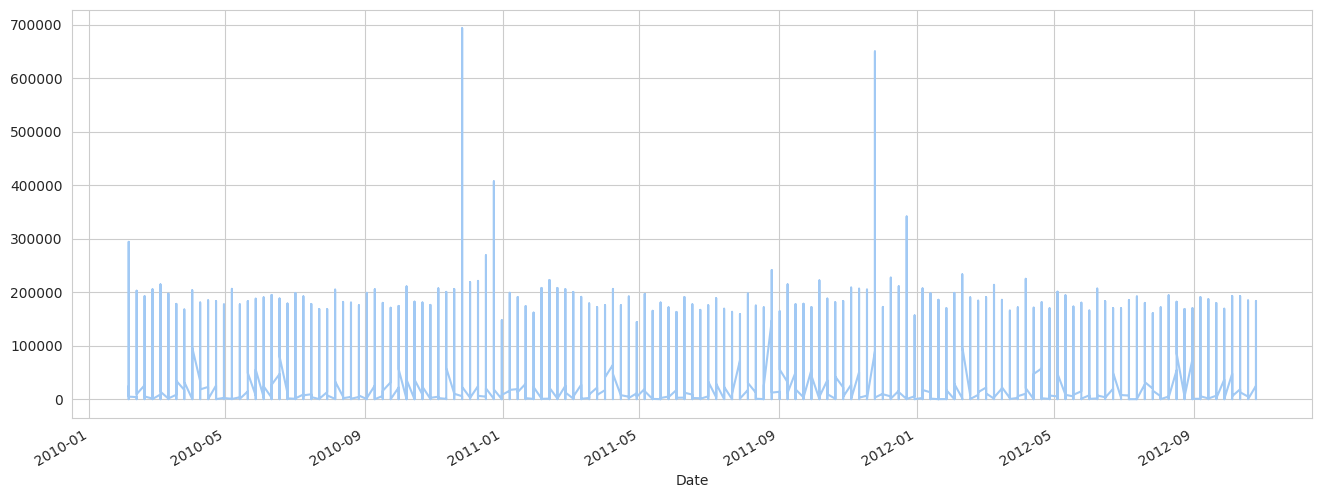

In [77]:
# Plotting sales

plt.figure(figsize=(16, 6))
df["Weekly_Sales"].plot()
plt.show()

Becaue the data has many sales values for a given week, I'll resample my data to remove this.

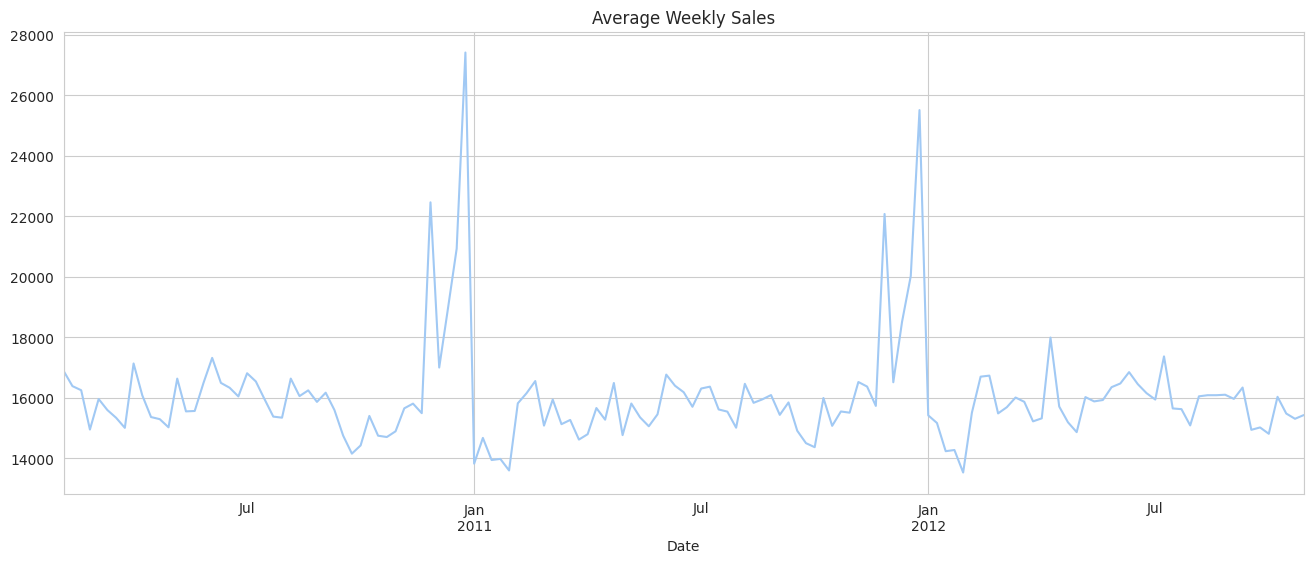

In [78]:
df_week = df.resample("W").mean()

plt.figure(figsize=(16, 6))
df_week["Weekly_Sales"].plot()
plt.title("Average Weekly Sales")
plt.show()

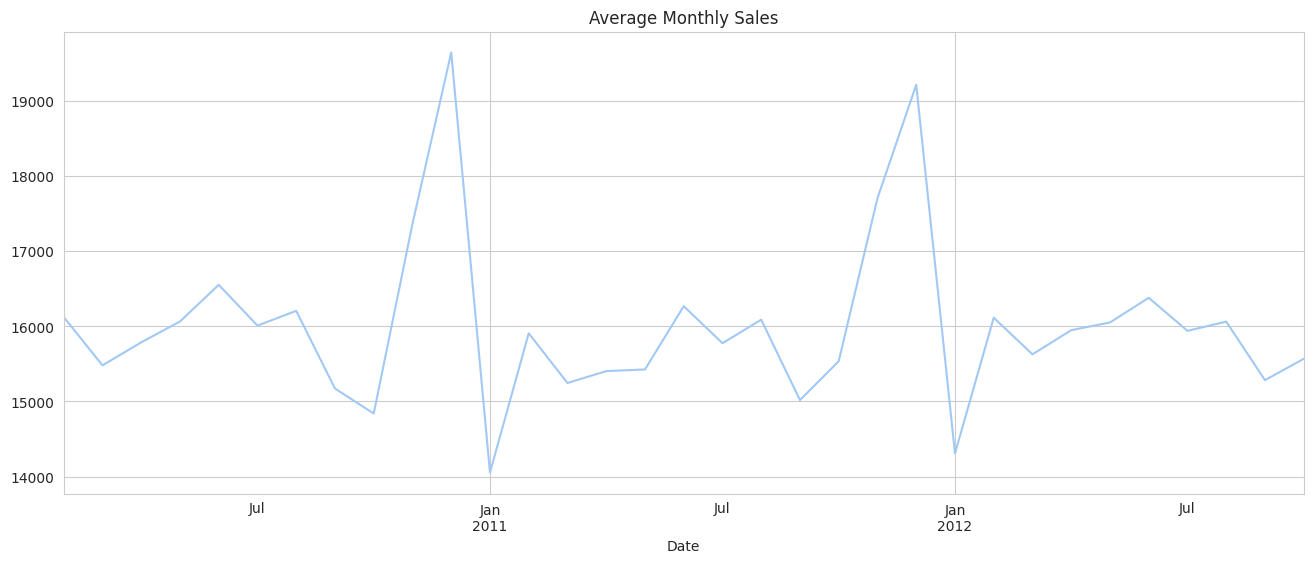

In [79]:
# Let's alos resample monthly

df_month = df.resample("M").mean()

plt.figure(figsize=(16, 6))
df_month["Weekly_Sales"].plot()
plt.title("Average Monthly Sales")
plt.show()

Resampling by month removes some of the trends seen in the weekly resampling. I'll keep the weekly resample as there is no loss of information there.

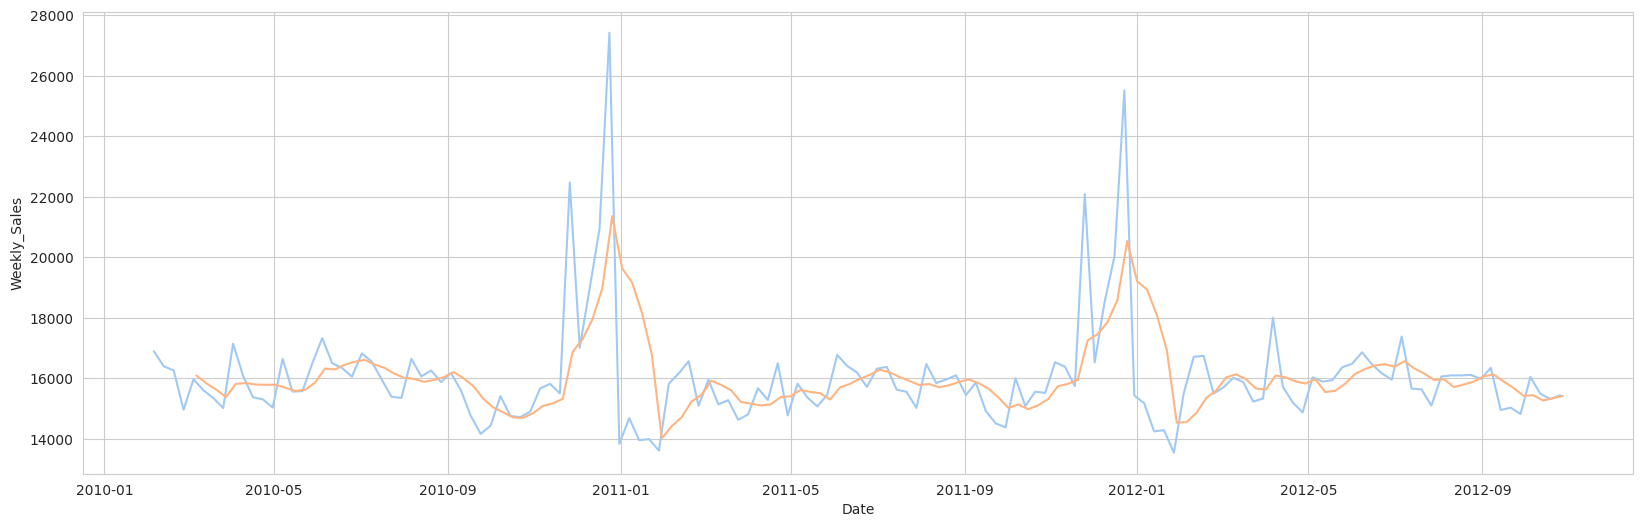

In [80]:
# Plotting Weekly_Sales vs Monthly mean

plt.figure(figsize=(20, 6))
sns.lineplot(data=df, x="Date", y="Weekly_Sales", errorbar=None)
sns.lineplot(x=df_week.index, y=df_week["Weekly_Sales"].rolling(window=5).mean(), errorbar=None)
plt.show()

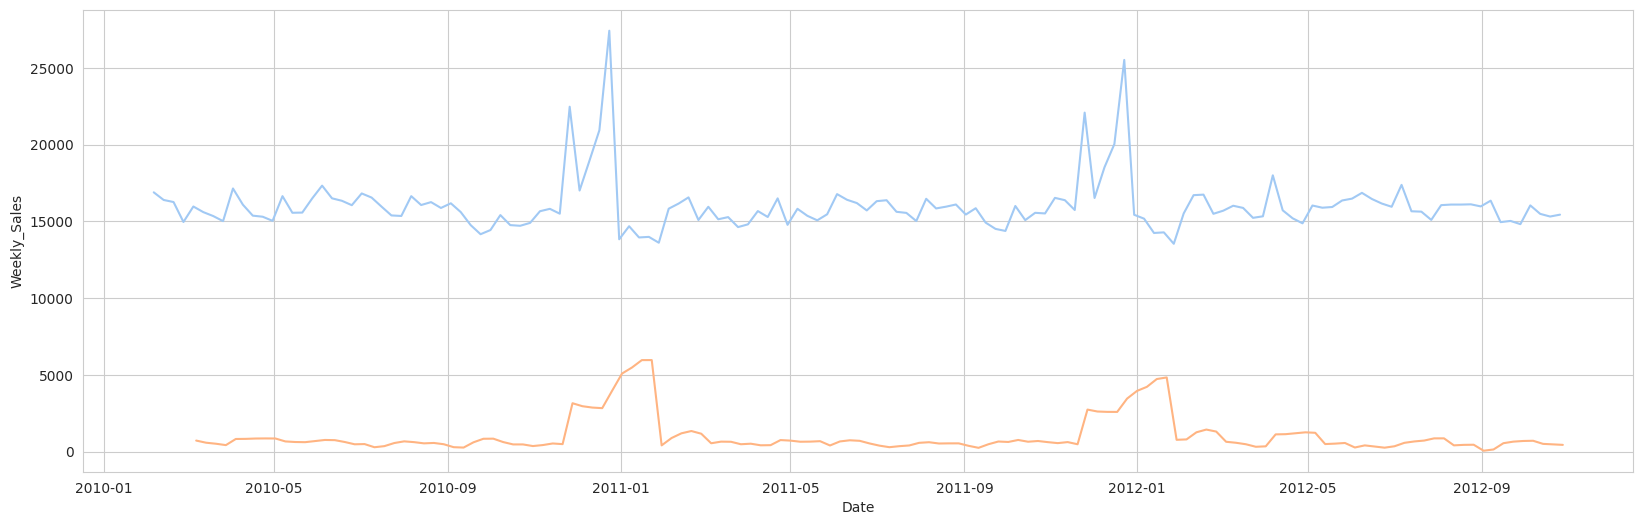

In [81]:
# Plotting Weekly_Sales vs Monthly std

plt.figure(figsize=(20, 6))
sns.lineplot(data=df, x="Date", y="Weekly_Sales", errorbar=None)
sns.lineplot(x=df_week.index, y=df_week["Weekly_Sales"].rolling(window=5).std(), errorbar=None)
plt.show()

From the graphs I can clearly see seasonality, the monthly mean goes up between November near Thanksgiving and then goes back down by February. The monthly standard deviation also follows this seasonality. Other than this seasonality, the data looks pretty stationary. I'll do an Augment Dicky Fuller test just to be sure.

In [82]:
weekly_sales = df_week["Weekly_Sales"].dropna().values
results = adfuller(weekly_sales, maxlag=15)

print(f"ADF Statistic: {results[0]}")
print(f"p-value: {results[1]}")
print(f"Critical values: {results[4]}")

if results[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is NOT stationary.")

ADF Statistic: -5.927107223737572
p-value: 2.4290492082042356e-07
Critical values: {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}
The time series is stationary.


So the time series is stationary and has seasonality, I can directly apply SARIMAX model on this time series. The seasonal frequency is 52 as we have weekly data.

In [83]:
n_train = int(0.7 * len(df_week))
train_data = df_week[:n_train]
test_data = df_week[n_train:]

In [84]:
model = auto_arima(train_data["Weekly_Sales"],
                   seasonal=True,
                   suppress_warnings=True,
                   error_action="ignore")
model_fit = model.fit(train_data["Weekly_Sales"])

In [85]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(5, 0, 0)   Log Likelihood                -886.959
Date:                Fri, 21 Feb 2025   AIC                           1787.917
Time:                        21:20:03   BIC                           1806.153
Sample:                    02-07-2010   HQIC                          1795.298
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9998.8794   1966.327      5.085      0.000    6144.949    1.39e+04
ar.L1          0.3316      0.060      5.519      0.000       0.214       0.449
ar.L2          0.1301      0.084      1.546      0.122      -0.035       0.295
ar.L3          0.0173      0.081      0.214      0.831      -0.141       0.176
ar.L4          0.3461      0.056      6.178      0.000       0.236       0.456
ar.L5         -0.4442      0.054     -8.301      0.000      -0.549      -0.339
sigma2      3.048e+06      5.678   5.37e+05      0.000    3.05e+06    3.05e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               190.51
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               6.57   Skew:                             1.93
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.12e+23. Standard errors may be unstable.
"""

In [86]:
y_test = test_data["Weekly_Sales"]
y_pred = model.predict(n_periods=len(test_data))
error = weighted_mean_absolute_error(y_test.values, y_pred.values, test_data=test_data)
print(f"Weighted mean absolute error (Auto ARIMA): {error:.2f}")

Weighted mean absolute error (Auto ARIMA): 854.82


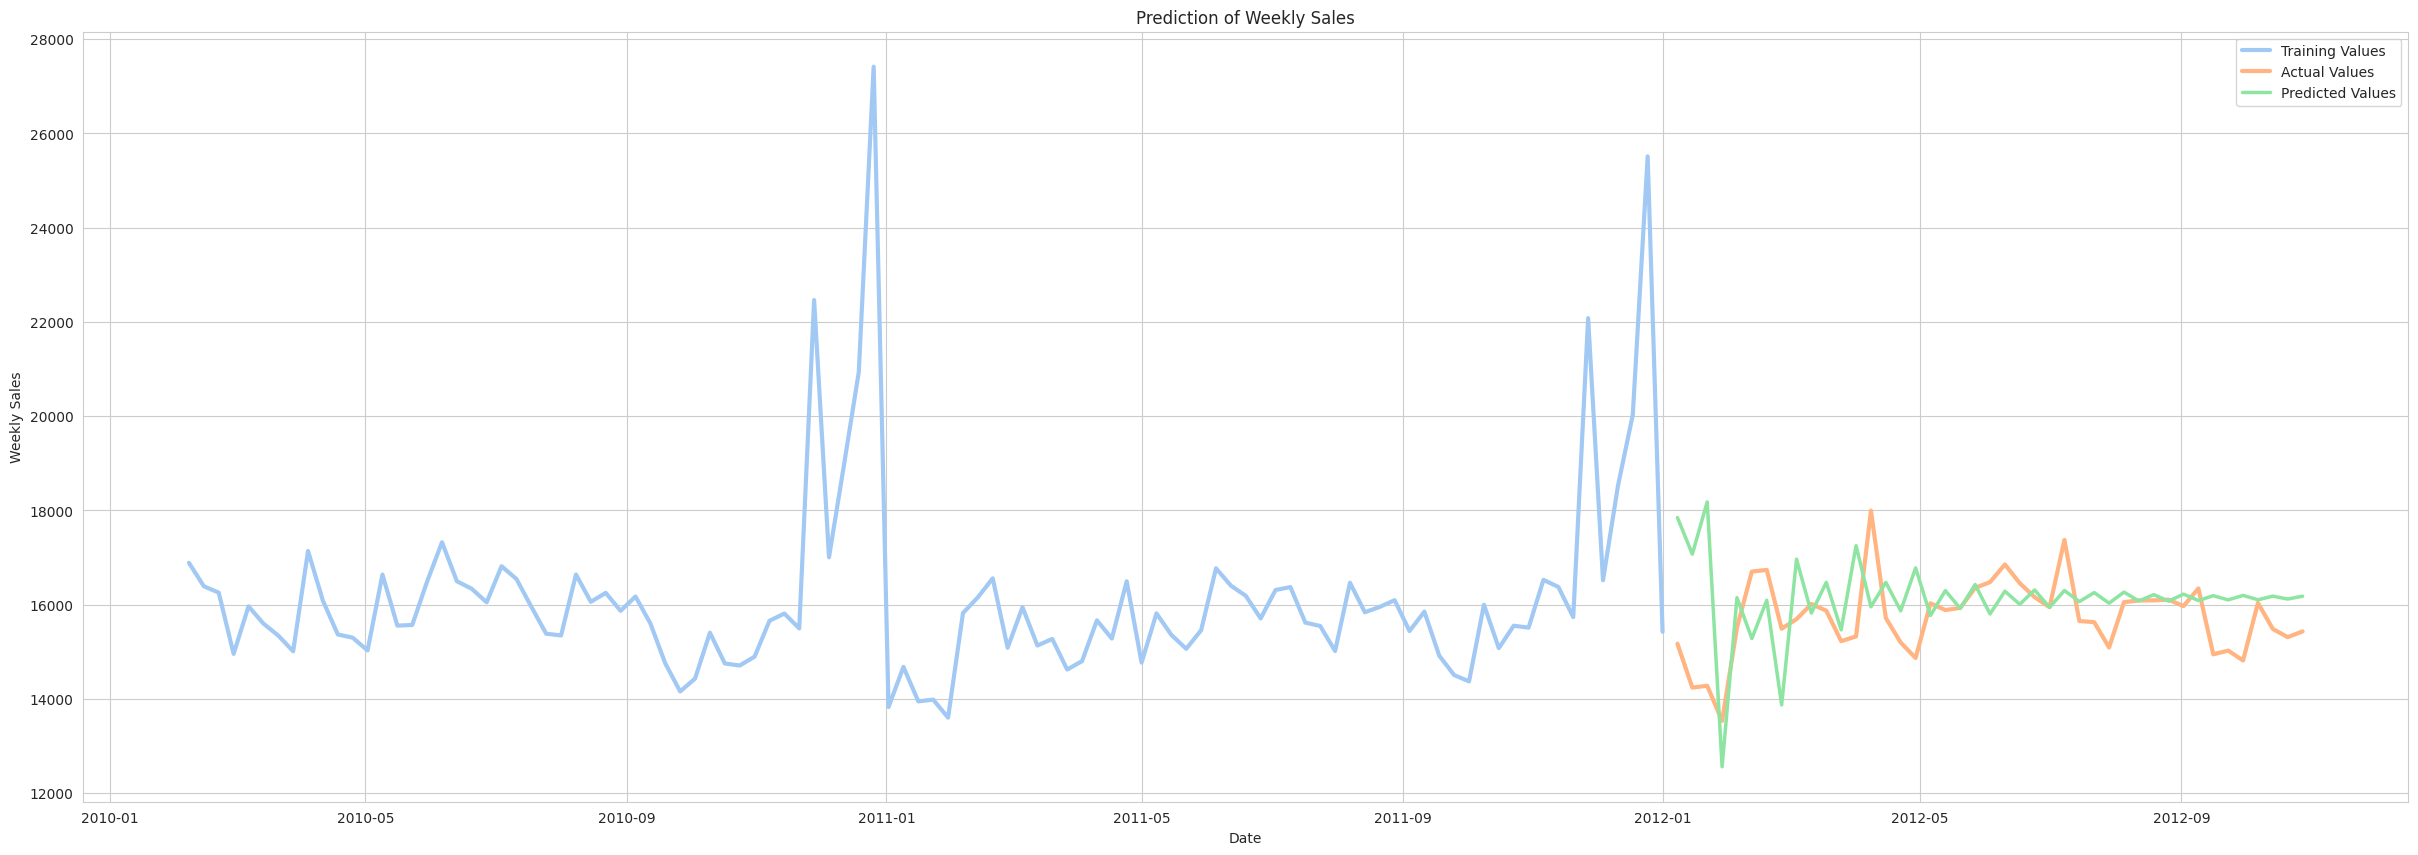

In [87]:
plot_model_predictions(y_pred=y_pred,
                       train_data=train_data,
                       test_data=test_data,
                       date_index=True)

In [88]:
holt_winter_model = ExponentialSmoothing(train_data["Weekly_Sales"],
                                         seasonal_periods=20,
                                         seasonal="multiplicative",
                                         trend="additive",
                                         damped=False).fit()

In [89]:
y_pred = holt_winter_model.forecast(len(test_data))
error = weighted_mean_absolute_error(y_test.values, y_pred.values, test_data=test_data)
print(f"Weighted mean absolute error (Holt Winter): {error:.2f}")

Weighted mean absolute error (Holt Winter): 3833.08


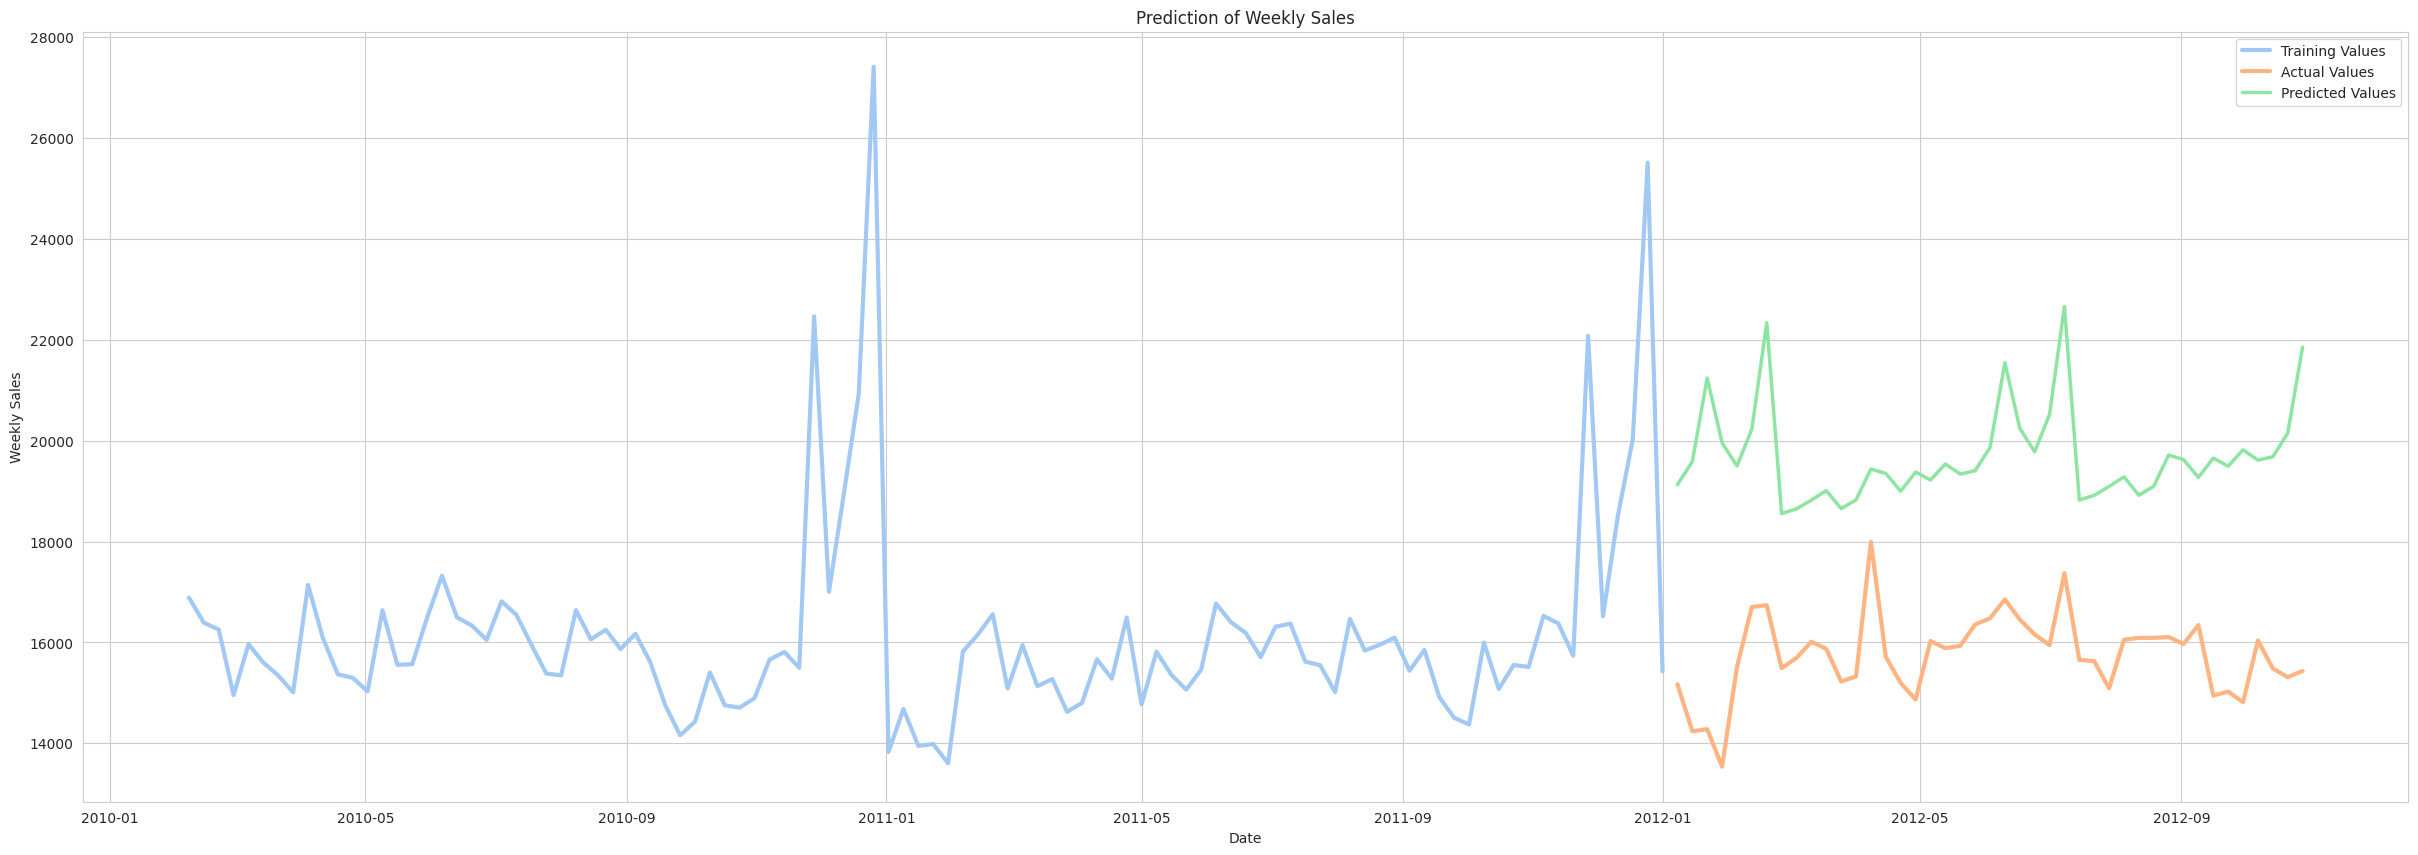

In [90]:
plot_model_predictions(y_pred=y_pred,
                       train_data=train_data,
                       test_data=test_data,
                       date_index=True)

In [91]:
data = {
    "Model": ["Linear Regression", "Random Forest Regressor", "Gradient Boosting Regressor", "ARIMA", "Exponential Smoothing"],
    "Weighted Mean Absolute Error": [1948.69, 1236.76, 1272.28, 854.82, 3833.08]
}

results_df = pd.DataFrame(data, index=range(1, len(data["Model"]) + 1))

In [92]:
results_df

,Model,Weighted Mean Absolute Error
1,Linear Regression,1948.69
2,Random Forest Regressor,1236.76
3,Gradient Boosting Regressor,1272.28
4,ARIMA,854.82
5,Exponential Smoothing,3833.08


## A/B Testing Simulation

I will now simulate a random A/B test to compare linear regression model and Random Forest Regressor model. To do this I will:

1. Read clean data and sort it on store and date.
2. Create forecasts using linear regression and random forest regressor.
3. Randomly assign half of the stores to control group and the other half to treatment group.
4. Compute error metric for both groups.
5. Perform t-test to find statistical significance.

In [93]:
df = pd.read_csv("clean_data.csv", index_col=0)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by=["Date"], ascending=True)

In [94]:
type_map = {"A": 1, "B": 2, "C": 3}
df["Type"] = df["Type"].apply(lambda x: type_map[x])

In [95]:
n_train = int(0.7 * len(df))
train_data = df.iloc[:n_train]
test_data = df.iloc[n_train:]

X_train = train_data.drop(columns=["Date", "Weekly_Sales"])
y_train = train_data["Weekly_Sales"]
X_test = test_data.drop(columns=["Date", "Weekly_Sales"])
y_test = test_data["Weekly_Sales"]

In [96]:
scaler = RobustScaler()
lr_model = LinearRegression()

pipe = Pipeline([
    ("Scaler", scaler),
    ("Regressor", lr_model)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('Scaler', RobustScaler()), ('Regressor', LinearRegression())])

In [97]:
y_pred_lr = pipe.predict(X_test)

In [98]:
columns_to_drop_rf = ["Christmas", "MarkDown5", "MarkDown4", "MarkDown1",
                      "MarkDown2", "IsHoliday", "Year", "Super_Bowl",
                      "Labor_Day"]

X_train_rf = X_train.drop(columns=columns_to_drop_rf)
X_test_rf = X_test.drop(columns=columns_to_drop_rf)

In [99]:
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features="sqrt",
                                     max_depth=30, min_samples_split=10)
pipe_rf = Pipeline([
    ("Scaler", scaler),
    ("Regressor", rf_regressor)
])

pipe.fit(X_train_rf, y_train)

Pipeline(steps=[('Scaler', RobustScaler()), ('Regressor', LinearRegression())])

In [100]:
y_pred_rf = pipe.predict(X_test_rf)

In [ ]:
# Randomly assign stores to control or treatment groups

np.random.seed(42)
groups = ["control", "treatment"]
test_data["Group"] = np.random.choice(groups, size=len(test_data))

In [102]:
test_data["Predictions"] = np.where(
    test_data["Group"] == "control",    # Condition to check
    y_pred_lr,                          # Value if true
    y_pred_rf                           # Value if false
)

In [103]:
test_data["AbsError"] = np.abs(test_data["Weekly_Sales"] - test_data["Predictions"])

In [104]:
test_data["Weights"] = np.where(
    test_data["IsHoliday"] == True,     # Condition to check
    5,                                  # Value if true
    1                                   # Value if false
)

In [105]:
test_data["WeightedAbsError"] = test_data["Weights"] * test_data["AbsError"]

In [106]:
control_df = test_data.loc[test_data["Group"] == "control"]
treatment_df = test_data.loc[test_data["Group"] == "treatment"]

In [107]:
wmae_control = control_df["WeightedAbsError"].sum() / control_df["Weights"].sum()
wmae_treatment = treatment_df["WeightedAbsError"].sum() / treatment_df["Weights"].sum()

In [108]:
print(f"WMAE Control (linear regression): {wmae_control:.2f}")
print(f"WMAE Treatment (random forest regression): {wmae_treatment:.2f}")

WMAE Control (linear regression): 1962.75
WMAE Treatment (random forest regression): 1241.88


In [109]:
# Performing the t-test

t_stat, p_value = ttest_ind(control_df["WeightedAbsError"],
                            treatment_df["WeightedAbsError"],
                            equal_var=False)

print(f"T-test statistic: {t_stat}")
print(f"T-test probability value: {p_value:.4f}")

if wmae_treatment < wmae_control and p_value < 0.05:
    print(f"Random forest model is statistically better.")
else:
    print(f"No statistical difference between random forest and linear regression models")

T-test statistic: 33.23351844911185
T-test probability value: 0.0000
Random forest model is statistically better.


In [112]:
percent_improve = ((wmae_control - wmae_treatment) / wmae_control) * 100
print(f"Improvement in weekly sales prediction over Linear Regression model: {percent_improve:.2f}%")

Improvement in weekly sales prediction over Linear Regression model: 36.73%


## Conclusion

Of all the different models, SARIMA is the best with the lowest weighted mean absolute error. Random Forest Regressor trained on reduced feature set was the best traditional model. I also performed an A/B test to compare linear regression model and random forest model and show that the random forest model is statistically better and improves sales prediction by over 30%.